# Problem Statement

A Chinese automobile company Geely Auto aspires to enter the US market by setting up their manufacturing unit there and producing cars locally to give competition to their US and European counterparts. 

They have contracted an automobile consulting company to understand the factors on which the pricing of cars depends. Specifically, they want to understand the factors affecting the pricing of cars in the American market, since those may be very different from the Chinese market. The company wants to know:

- Which variables are significant in predicting the price of a car
- How well those variables describe the price of a car

Based on various market surveys, the consulting firm has gathered a large dataset of different types of cars across the Americal market. 

In [1203]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

# Load the Cars Dataset

In [1204]:
# Read the data
cars=pd.read_csv('CarPrice_Assignment.csv')

In [1205]:
# Visualize the Data
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

In [1206]:
cars.shape

(205, 26)

In [1207]:
cars.head()

car_ID  symboling                   CarName fueltype aspiration doornumber  \
0       1          3        alfa-romero giulia      gas        std        two   
1       2          3       alfa-romero stelvio      gas        std        two   
2       3          1  alfa-romero Quadrifoglio      gas        std        two   
3       4          2               audi 100 ls      gas        std       four   
4       5          2                audi 100ls      gas        std       four   

       carbody drivewheel enginelocation  wheelbase  carlength  carwidth  \
0  convertible        rwd          front       88.6      168.8      64.1   
1  convertible        rwd          front       88.6      168.8      64.1   
2    hatchback        rwd          front       94.5      171.2      65.5   
3        sedan        fwd          front       99.8      176.6      66.2   
4        sedan        4wd          front       99.4      176.6      66.4   

   carheight  curbweight enginetype cylindernumber  enginesize fuelsystem  \
0       48.8        2548       dohc           four         130       mpfi   
1       48.8        2548       dohc           four         130       mpfi   
2       52.4        2823       ohcv            six         152       mpfi   
3       54.3        2337        ohc           four         109       mpfi   
4       54.3        2824        ohc           five         136       mpfi   

   boreratio  stroke  compressionratio  horsepower  peakrpm  citympg  \
0       3.47    2.68               9.0         111     5000       21   
1       3.47    2.68               9.0         111     5000       21   
2       2.68    3.47               9.0         154     5000       19   
3       3.19    3.40              10.0         102     5500       24   
4       3.19    3.40               8.0         115     5500       18   

   highwaympg    price  
0          27  13495.0  
1          27  16500.0  
2          26  16500.0  
3          30  13950.0  
4          22  17450.0

In [1208]:
# Verify data for missing values. Shows there are no missing values
cars.isnull().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

# Data Preparation and Cleaning

- There is a variable named CarName which is comprised of two parts - the first word is the name of 'car company' and the second is the 'car model'. For example, chevrolet impala has 'chevrolet' as the car company name and 'impala' as the car model name. You need to consider only company name as the independent variable for model building. 

In [1209]:
# Creating 2 features by splitting CarName. Company Name and model name
cars['companyname'] = cars.CarName.str.split(n=1).map(lambda x:x[0])
cars['model'] = cars.CarName.str.split(n=1).map(lambda x:x[-1])

# Drop the CarName feature from the dataset 
cars.drop('CarName',axis=1,inplace=True)

# Verify after drop
cars.head()

car_ID  symboling fueltype aspiration doornumber      carbody drivewheel  \
0       1          3      gas        std        two  convertible        rwd   
1       2          3      gas        std        two  convertible        rwd   
2       3          1      gas        std        two    hatchback        rwd   
3       4          2      gas        std       four        sedan        fwd   
4       5          2      gas        std       four        sedan        4wd   

  enginelocation  wheelbase  carlength  carwidth  carheight  curbweight  \
0          front       88.6      168.8      64.1       48.8        2548   
1          front       88.6      168.8      64.1       48.8        2548   
2          front       94.5      171.2      65.5       52.4        2823   
3          front       99.8      176.6      66.2       54.3        2337   
4          front       99.4      176.6      66.4       54.3        2824   

  enginetype cylindernumber  enginesize fuelsystem  boreratio  stroke  \
0       dohc           four         130       mpfi       3.47    2.68   
1       dohc           four         130       mpfi       3.47    2.68   
2       ohcv            six         152       mpfi       2.68    3.47   
3        ohc           four         109       mpfi       3.19    3.40   
4        ohc           five         136       mpfi       3.19    3.40   

   compressionratio  horsepower  peakrpm  citympg  highwaympg    price  \
0               9.0         111     5000       21          27  13495.0   
1               9.0         111     5000       21          27  16500.0   
2               9.0         154     5000       19          26  16500.0   
3              10.0         102     5500       24          30  13950.0   
4               8.0         115     5500       18          22  17450.0   

   companyname         model  
0  alfa-romero        giulia  
1  alfa-romero       stelvio  
2  alfa-romero  Quadrifoglio  
3         audi        100 ls  
4         audi         100ls

In [1210]:
cars.columns

Index(['car_ID', 'symboling', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'enginetype', 'cylindernumber',
       'enginesize', 'fuelsystem', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price',
       'companyname', 'model'],
      dtype='object')

In [1211]:
# Checking number of unique values for each feature
cars.nunique()

car_ID              205
symboling             6
fueltype              2
aspiration            2
doornumber            2
carbody               5
drivewheel            3
enginelocation        2
wheelbase            53
carlength            75
carwidth             44
carheight            49
curbweight          171
enginetype            7
cylindernumber        7
enginesize           44
fuelsystem            8
boreratio            38
stroke               37
compressionratio     32
horsepower           59
peakrpm              23
citympg              29
highwaympg           30
price               189
companyname          28
model               142
dtype: int64

In [1212]:
# Car_ID and model has very high number of unique values compared to total number of rows. 
# They would not add any predictive power to the model hence dropping 
cars.drop(['car_ID','model'],axis=1,inplace=True)
cars.head()

symboling fueltype aspiration doornumber      carbody drivewheel  \
0          3      gas        std        two  convertible        rwd   
1          3      gas        std        two  convertible        rwd   
2          1      gas        std        two    hatchback        rwd   
3          2      gas        std       four        sedan        fwd   
4          2      gas        std       four        sedan        4wd   

  enginelocation  wheelbase  carlength  carwidth  carheight  curbweight  \
0          front       88.6      168.8      64.1       48.8        2548   
1          front       88.6      168.8      64.1       48.8        2548   
2          front       94.5      171.2      65.5       52.4        2823   
3          front       99.8      176.6      66.2       54.3        2337   
4          front       99.4      176.6      66.4       54.3        2824   

  enginetype cylindernumber  enginesize fuelsystem  boreratio  stroke  \
0       dohc           four         130       mpfi       3.47    2.68   
1       dohc           four         130       mpfi       3.47    2.68   
2       ohcv            six         152       mpfi       2.68    3.47   
3        ohc           four         109       mpfi       3.19    3.40   
4        ohc           five         136       mpfi       3.19    3.40   

   compressionratio  horsepower  peakrpm  citympg  highwaympg    price  \
0               9.0         111     5000       21          27  13495.0   
1               9.0         111     5000       21          27  16500.0   
2               9.0         154     5000       19          26  16500.0   
3              10.0         102     5500       24          30  13950.0   
4               8.0         115     5500       18          22  17450.0   

   companyname  
0  alfa-romero  
1  alfa-romero  
2  alfa-romero  
3         audi  
4         audi

In [1213]:
# Find number of unique values in each columns
(cars.nunique() < 10)

symboling            True
fueltype             True
aspiration           True
doornumber           True
carbody              True
drivewheel           True
enginelocation       True
wheelbase           False
carlength           False
carwidth            False
carheight           False
curbweight          False
enginetype           True
cylindernumber       True
enginesize          False
fuelsystem           True
boreratio           False
stroke              False
compressionratio    False
horsepower          False
peakrpm             False
citympg             False
highwaympg          False
price               False
companyname         False
dtype: bool

In [1214]:
# We will add all columns having less than 10 unique values and the company name column from our business understanding
cat_cols = ['symboling','fueltype','aspiration','doornumber','carbody','companyname',
            'drivewheel','enginelocation','enginetype','cylindernumber','fuelsystem']
cat_cols

['symboling',
 'fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'companyname',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem']

In [1215]:
# All columns other than categorical columns are numeric columns. Minus operation
num_cols = list(set(cars.columns) - set(cat_cols))
num_cols

['stroke',
 'curbweight',
 'wheelbase',
 'carwidth',
 'enginesize',
 'boreratio',
 'highwaympg',
 'citympg',
 'peakrpm',
 'carheight',
 'carlength',
 'horsepower',
 'compressionratio',
 'price']

In [1216]:
# There are spelling errors for some company names e.g 'maxda,mazda','toyota,toyouta' etc. We need correct the same.
cars.companyname.value_counts().sort_index()

Nissan          1
alfa-romero     3
audi            7
bmw             8
buick           8
chevrolet       3
dodge           9
honda          13
isuzu           4
jaguar          3
maxda           2
mazda          15
mercury         1
mitsubishi     13
nissan         17
peugeot        11
plymouth        7
porcshce        1
porsche         4
renault         2
saab            6
subaru         12
toyota         31
toyouta         1
vokswagen       1
volkswagen      9
volvo          11
vw              2
Name: companyname, dtype: int64

In [1217]:
# Create a function to correct the spelling errors in car company names
def map_companyname(x):
    if x == 'maxda': return 'mazda'
    elif x == 'porcshce': return 'porsche'
    elif x == 'toyouta': return 'toyota'
    elif x == 'vokswagen': return 'volkswagen'
    elif x == 'vw': return 'volkswagen'
    else: return x

# Fix the company names    
cars['companyname'] = cars['companyname'].map(map_companyname)

# Verify after mapping is done
cars['companyname'].value_counts().sort_index()

Nissan          1
alfa-romero     3
audi            7
bmw             8
buick           8
chevrolet       3
dodge           9
honda          13
isuzu           4
jaguar          3
mazda          17
mercury         1
mitsubishi     13
nissan         17
peugeot        11
plymouth        7
porsche         5
renault         2
saab            6
subaru         12
toyota         32
volkswagen     12
volvo          11
Name: companyname, dtype: int64

### Check the unique values of rest of the Categorical columns

In [1218]:
cars['symboling'].value_counts()

 0    67
 1    54
 2    32
 3    27
-1    22
-2     3
Name: symboling, dtype: int64

In [1219]:
cars['fueltype'].value_counts()

gas       185
diesel     20
Name: fueltype, dtype: int64

In [1220]:
cars['aspiration'].value_counts()

std      168
turbo     37
Name: aspiration, dtype: int64

In [1221]:
cars['doornumber'].value_counts()

four    115
two      90
Name: doornumber, dtype: int64

In [1222]:
cars['carbody'].value_counts()

sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: carbody, dtype: int64

In [1223]:
cars['drivewheel'].value_counts()

fwd    120
rwd     76
4wd      9
Name: drivewheel, dtype: int64

In [1224]:
cars['enginelocation'].value_counts()

front    202
rear       3
Name: enginelocation, dtype: int64

In [1225]:
cars['enginetype'].value_counts()

ohc      148
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
dohcv      1
Name: enginetype, dtype: int64

In [1226]:
cars['cylindernumber'].value_counts()

four      159
six        24
five       11
eight       5
two         4
three       1
twelve      1
Name: cylindernumber, dtype: int64

In [1227]:
cars['fuelsystem'].value_counts()

mpfi    94
2bbl    66
idi     20
1bbl    11
spdi     9
4bbl     3
mfi      1
spfi     1
Name: fuelsystem, dtype: int64

# Data Visualization 

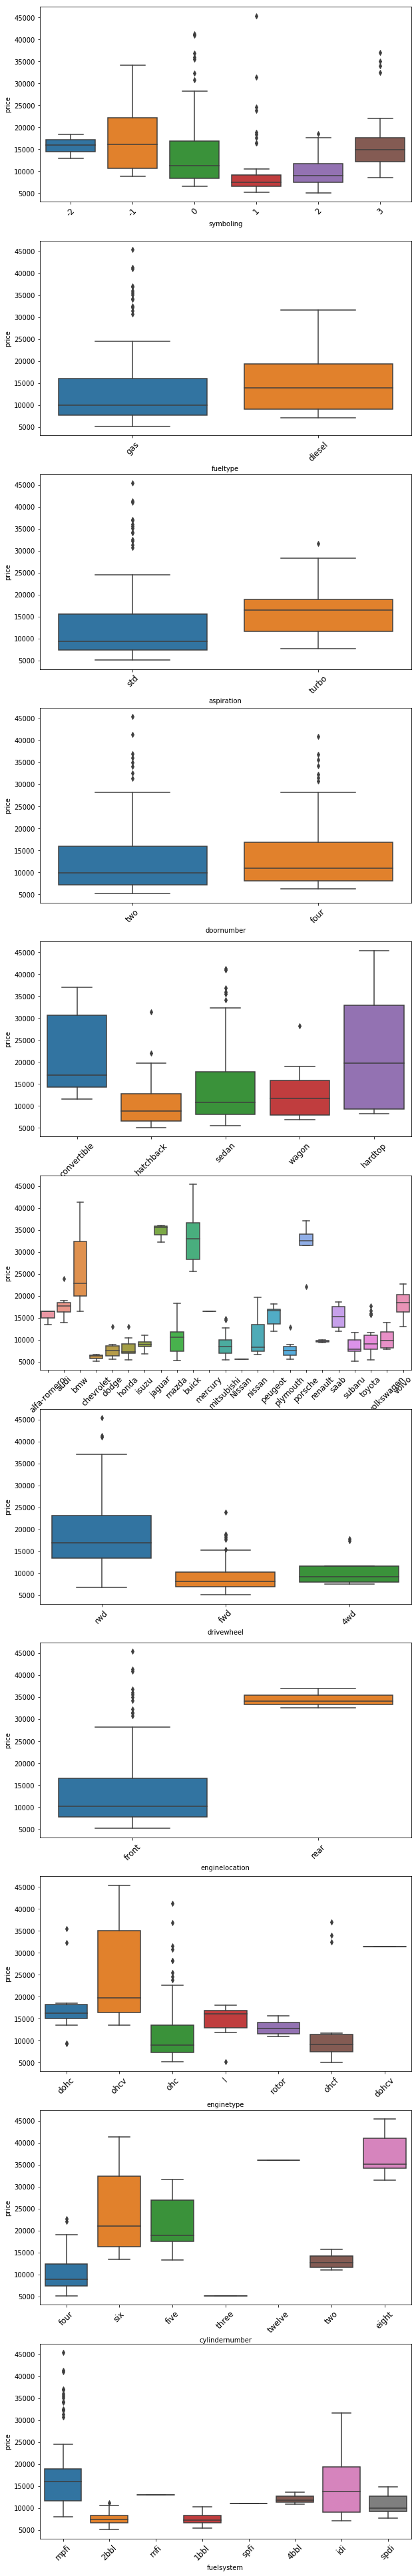

In [1228]:
# Seaborn box plots for all categorical columns versus price
plt.figure(figsize=(10,70))
for i,col in enumerate(cat_cols):
    plt.subplot(11,1,i+1)
    sns.boxplot(x=col,y='price',data=cars)
    plt.xticks(rotation=45,fontsize=12)

#### Inferences:-
- Negative symboling cars have higher median price. Hence safer cars are priced higher.
- Diesel cars have higher median price
- Turbo aspiration cars are priced higher than std.
- Convertible and hard top cars have higher price than other cars.
- BMW,Jaguar,Buick,Porche is priced higher.
- rwd cars are priced higher
- Rear Engine location cars are priced higher
- Higher the cyclinder number higher is the price of cars

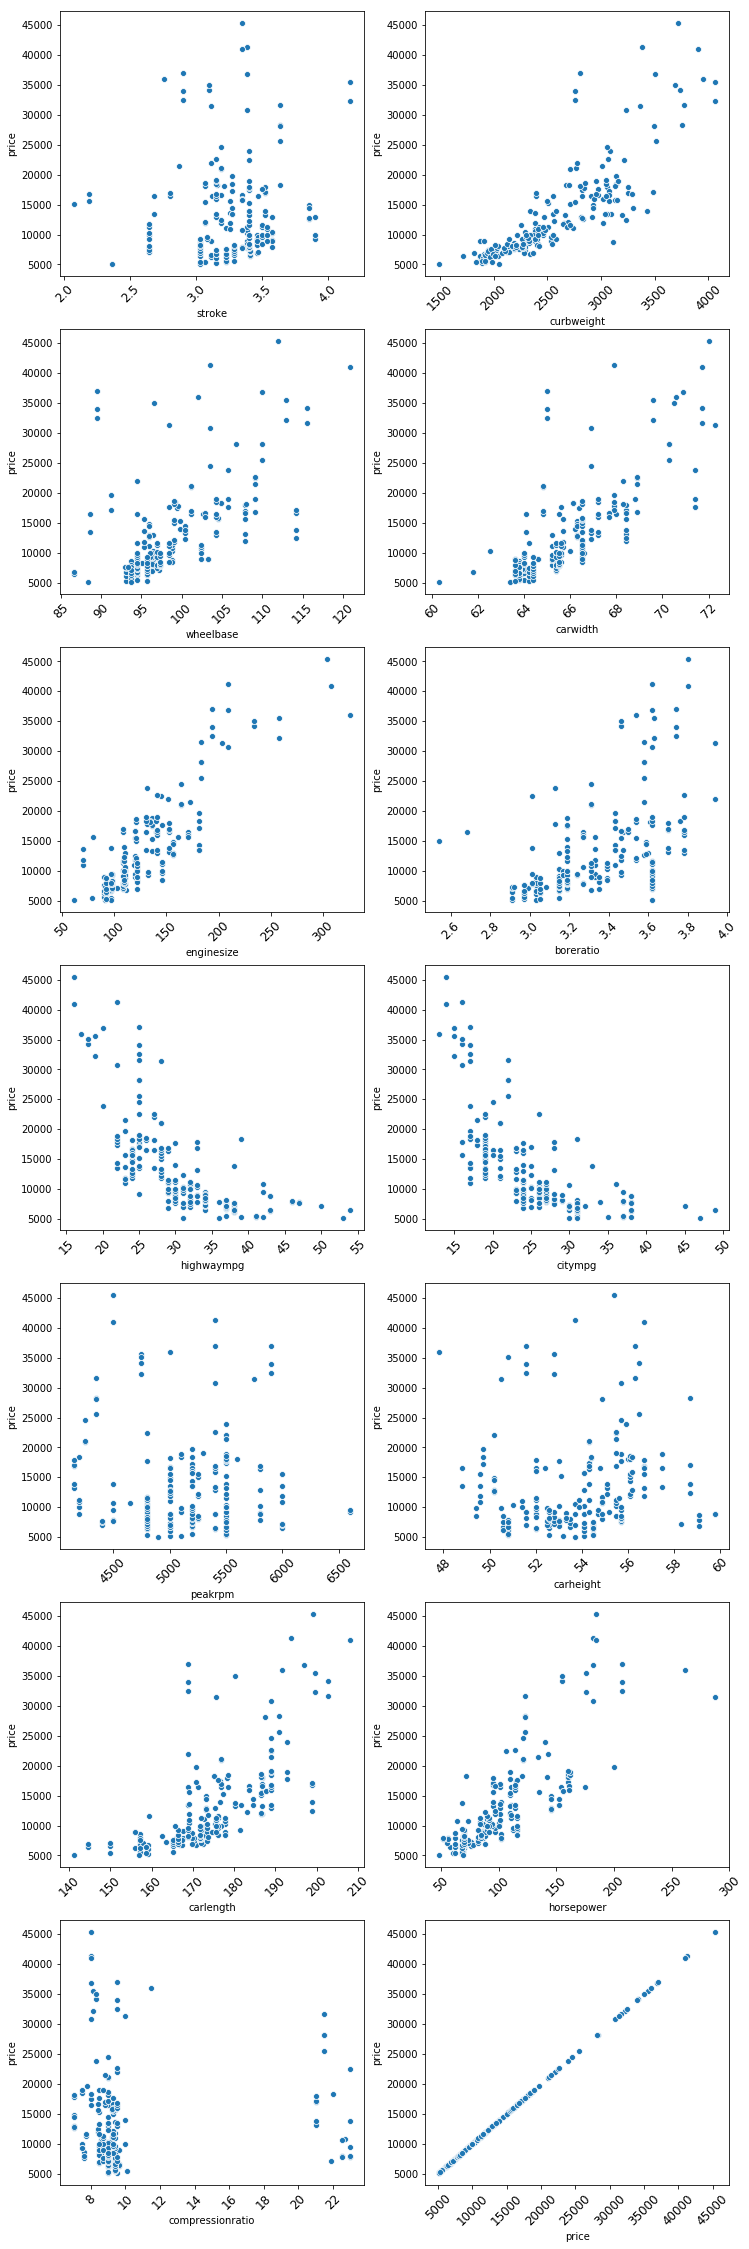

In [1229]:
# Seaborn scatter plots for all numerical columns versus price
plt.figure(figsize=(12,40))
for i,col in enumerate(num_cols):
    plt.subplot(7,2,i+1)
    sns.scatterplot(x=col,y='price',data=cars)
    plt.xticks(rotation=45,fontsize=12)

### Inferences
- Higher the curbweight higher the price
- Higher the horsepower higher the price
- Higher the city/highway mpg lesser the price
- Higher the wheelbase higher the price
- Higher the engine size higher the price

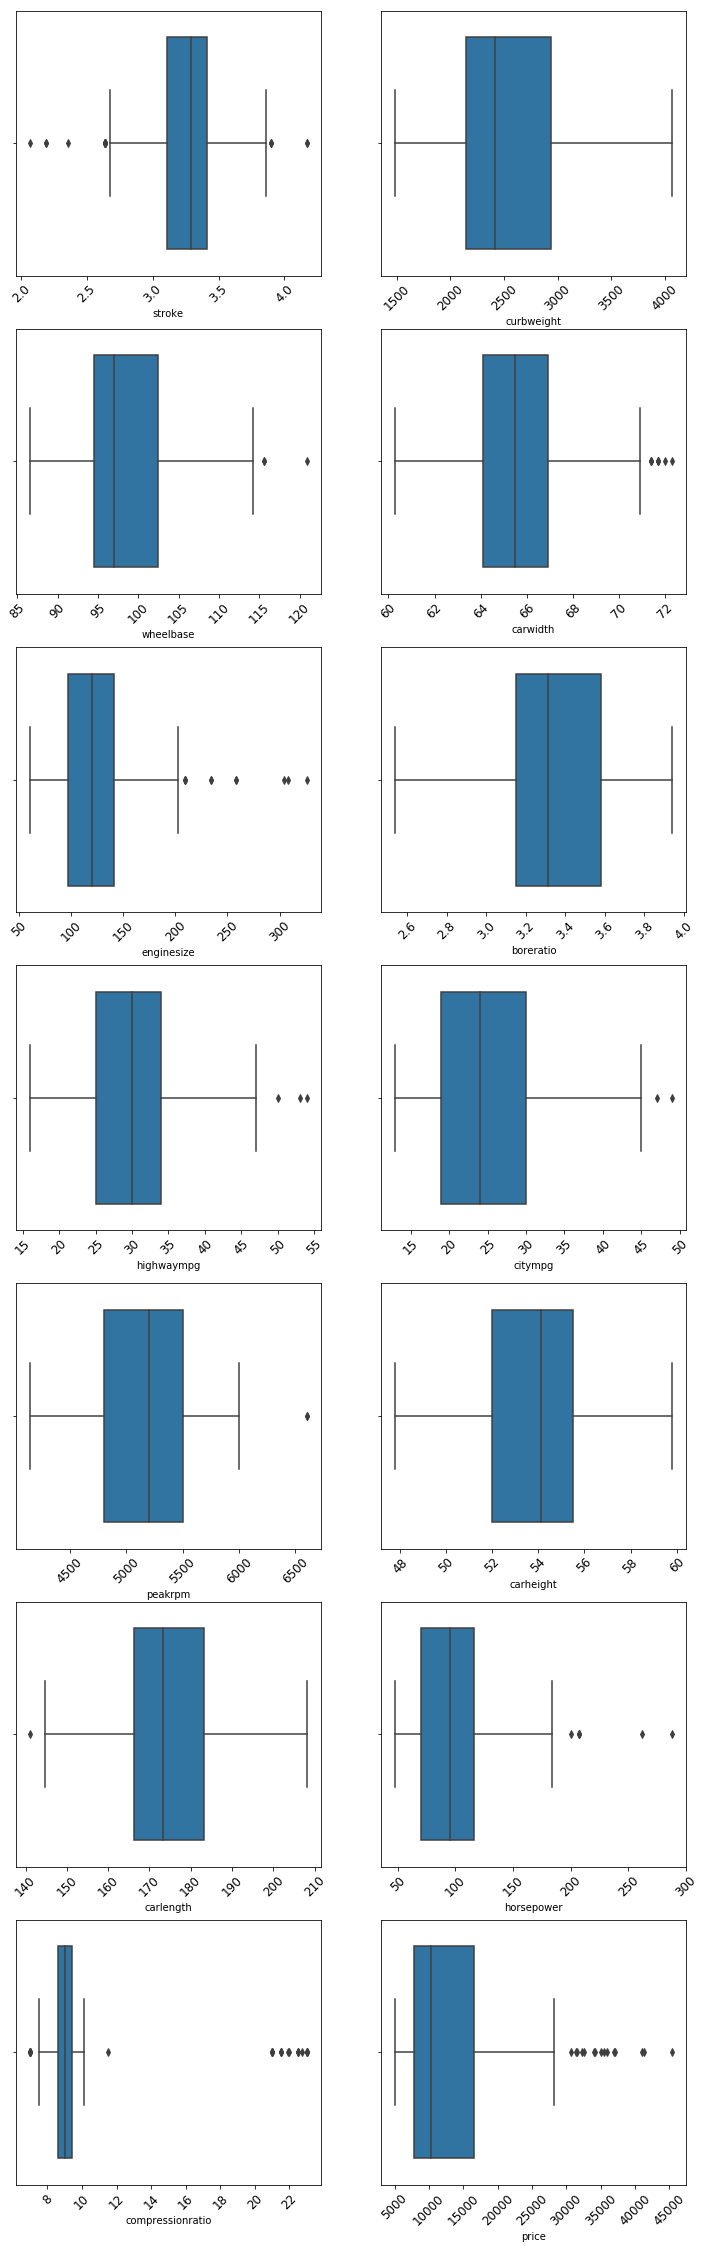

In [1230]:
# Seaborn univariate box plots for all numerical columns to check for ditribution and outliers
plt.figure(figsize=(12,40))
for i,col in enumerate(num_cols):
    plt.subplot(7,2,i+1)
    sns.boxplot(x=col,data=cars)
    plt.xticks(rotation=45,fontsize=12)

## Categorical Variable Encoding

In [1231]:
# Using Pandas to encode all categorical variables.
cars = pd.get_dummies(cars,columns=cat_cols,drop_first=True)

In [1232]:
# Visualize
cars.head()

wheelbase  carlength  carwidth  carheight  curbweight  enginesize  \
0       88.6      168.8      64.1       48.8        2548         130   
1       88.6      168.8      64.1       48.8        2548         130   
2       94.5      171.2      65.5       52.4        2823         152   
3       99.8      176.6      66.2       54.3        2337         109   
4       99.4      176.6      66.4       54.3        2824         136   

   boreratio  stroke  compressionratio  horsepower  peakrpm  citympg  \
0       3.47    2.68               9.0         111     5000       21   
1       3.47    2.68               9.0         111     5000       21   
2       2.68    3.47               9.0         154     5000       19   
3       3.19    3.40              10.0         102     5500       24   
4       3.19    3.40               8.0         115     5500       18   

   highwaympg    price  symboling_-1  symboling_0  symboling_1  symboling_2  \
0          27  13495.0             0            0            0            0   
1          27  16500.0             0            0            0            0   
2          26  16500.0             0            0            1            0   
3          30  13950.0             0            0            0            1   
4          22  17450.0             0            0            0            1   

   symboling_3  fueltype_gas  aspiration_turbo  doornumber_two  \
0            1             1                 0               1   
1            1             1                 0               1   
2            0             1                 0               1   
3            0             1                 0               0   
4            0             1                 0               0   

   carbody_hardtop  carbody_hatchback  carbody_sedan  carbody_wagon  \
0                0                  0              0              0   
1                0                  0              0              0   
2                0                  1              0              0   
3                0                  0              1              0   
4                0                  0              1              0   

   companyname_alfa-romero  companyname_audi  companyname_bmw  \
0                        1                 0                0   
1                        1                 0                0   
2                        1                 0                0   
3                        0                 1                0   
4                        0                 1                0   

   companyname_buick  companyname_chevrolet  companyname_dodge  \
0                  0                      0                  0   
1                  0                      0                  0   
2                  0                      0                  0   
3                  0                      0                  0   
4                  0                      0                  0   

   companyname_honda  companyname_isuzu  companyname_jaguar  \
0                  0                  0                   0   
1                  0                  0                   0   
2                  0                  0                   0   
3                  0                  0                   0   
4                  0                  0                   0   

   companyname_mazda  companyname_mercury  companyname_mitsubishi  \
0                  0                    0                       0   
1                  0                    0                       0   
2                  0                    0                       0   
3                  0                    0                       0   
4                  0                    0                       0   

   companyname_nissan  companyname_peugeot  companyname_plymouth  \
0                   0                    0                     0   
1                   0                    0                     0   
2                   0                    0          

In [1233]:
cars.shape

(205, 70)

In [1234]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 70 columns):
wheelbase                  205 non-null float64
carlength                  205 non-null float64
carwidth                   205 non-null float64
carheight                  205 non-null float64
curbweight                 205 non-null int64
enginesize                 205 non-null int64
boreratio                  205 non-null float64
stroke                     205 non-null float64
compressionratio           205 non-null float64
horsepower                 205 non-null int64
peakrpm                    205 non-null int64
citympg                    205 non-null int64
highwaympg                 205 non-null int64
price                      205 non-null float64
symboling_-1               205 non-null uint8
symboling_0                205 non-null uint8
symboling_1                205 non-null uint8
symboling_2                205 non-null uint8
symboling_3                205 non-null uint8
fuelt

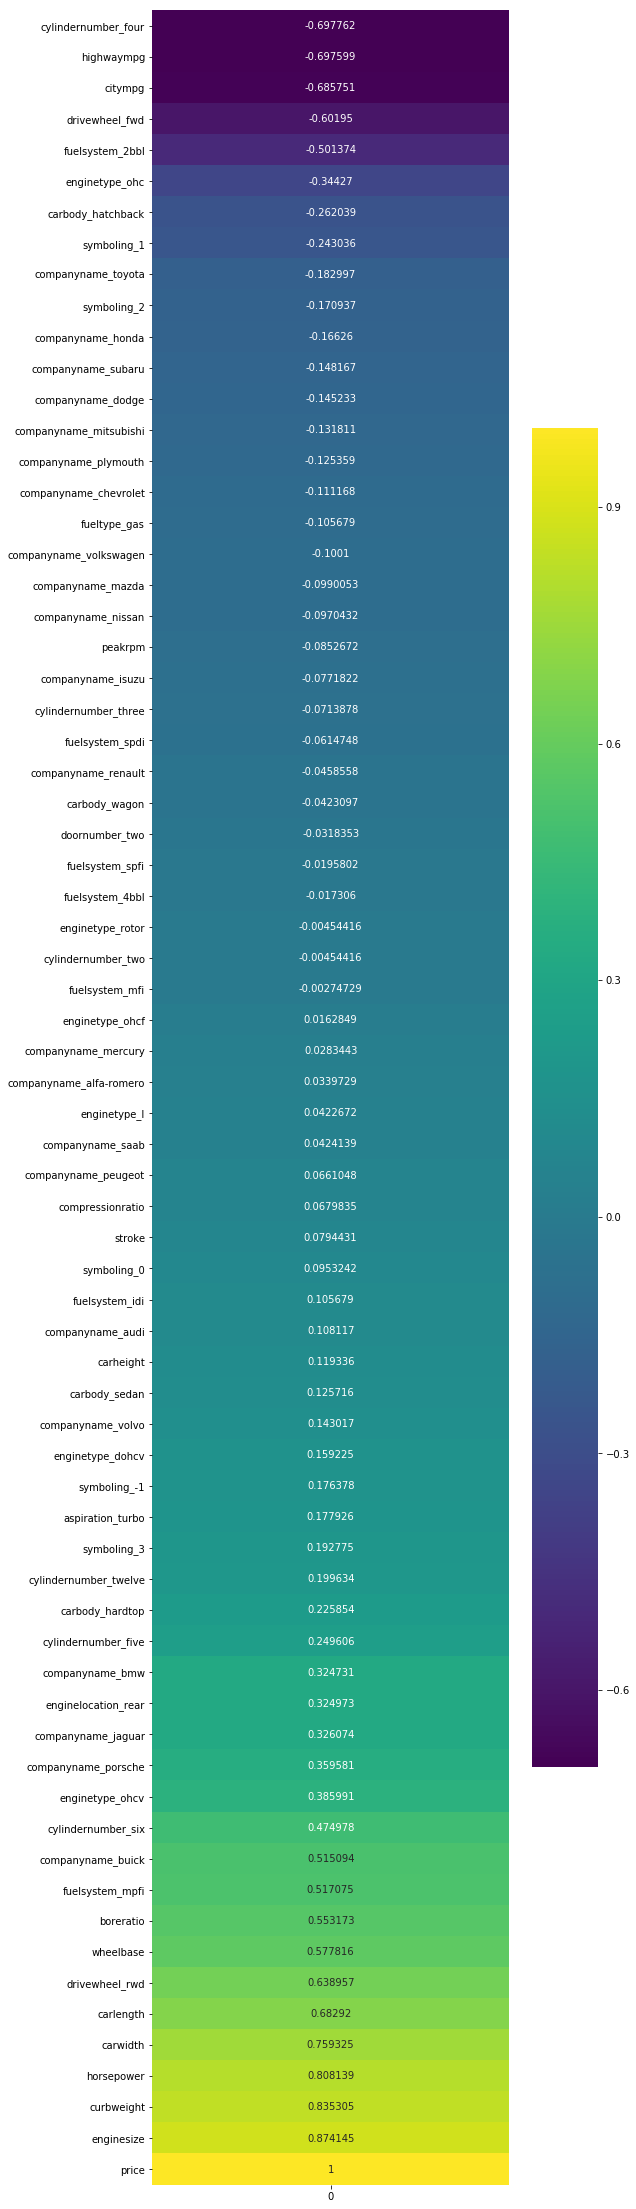

In [1235]:
# Correlation of all features with price column.
plt.figure(figsize=(8,40))
sns.heatmap(pd.DataFrame(cars.corrwith(cars.price).sort_values()),annot=True,fmt="g", cmap='viridis')

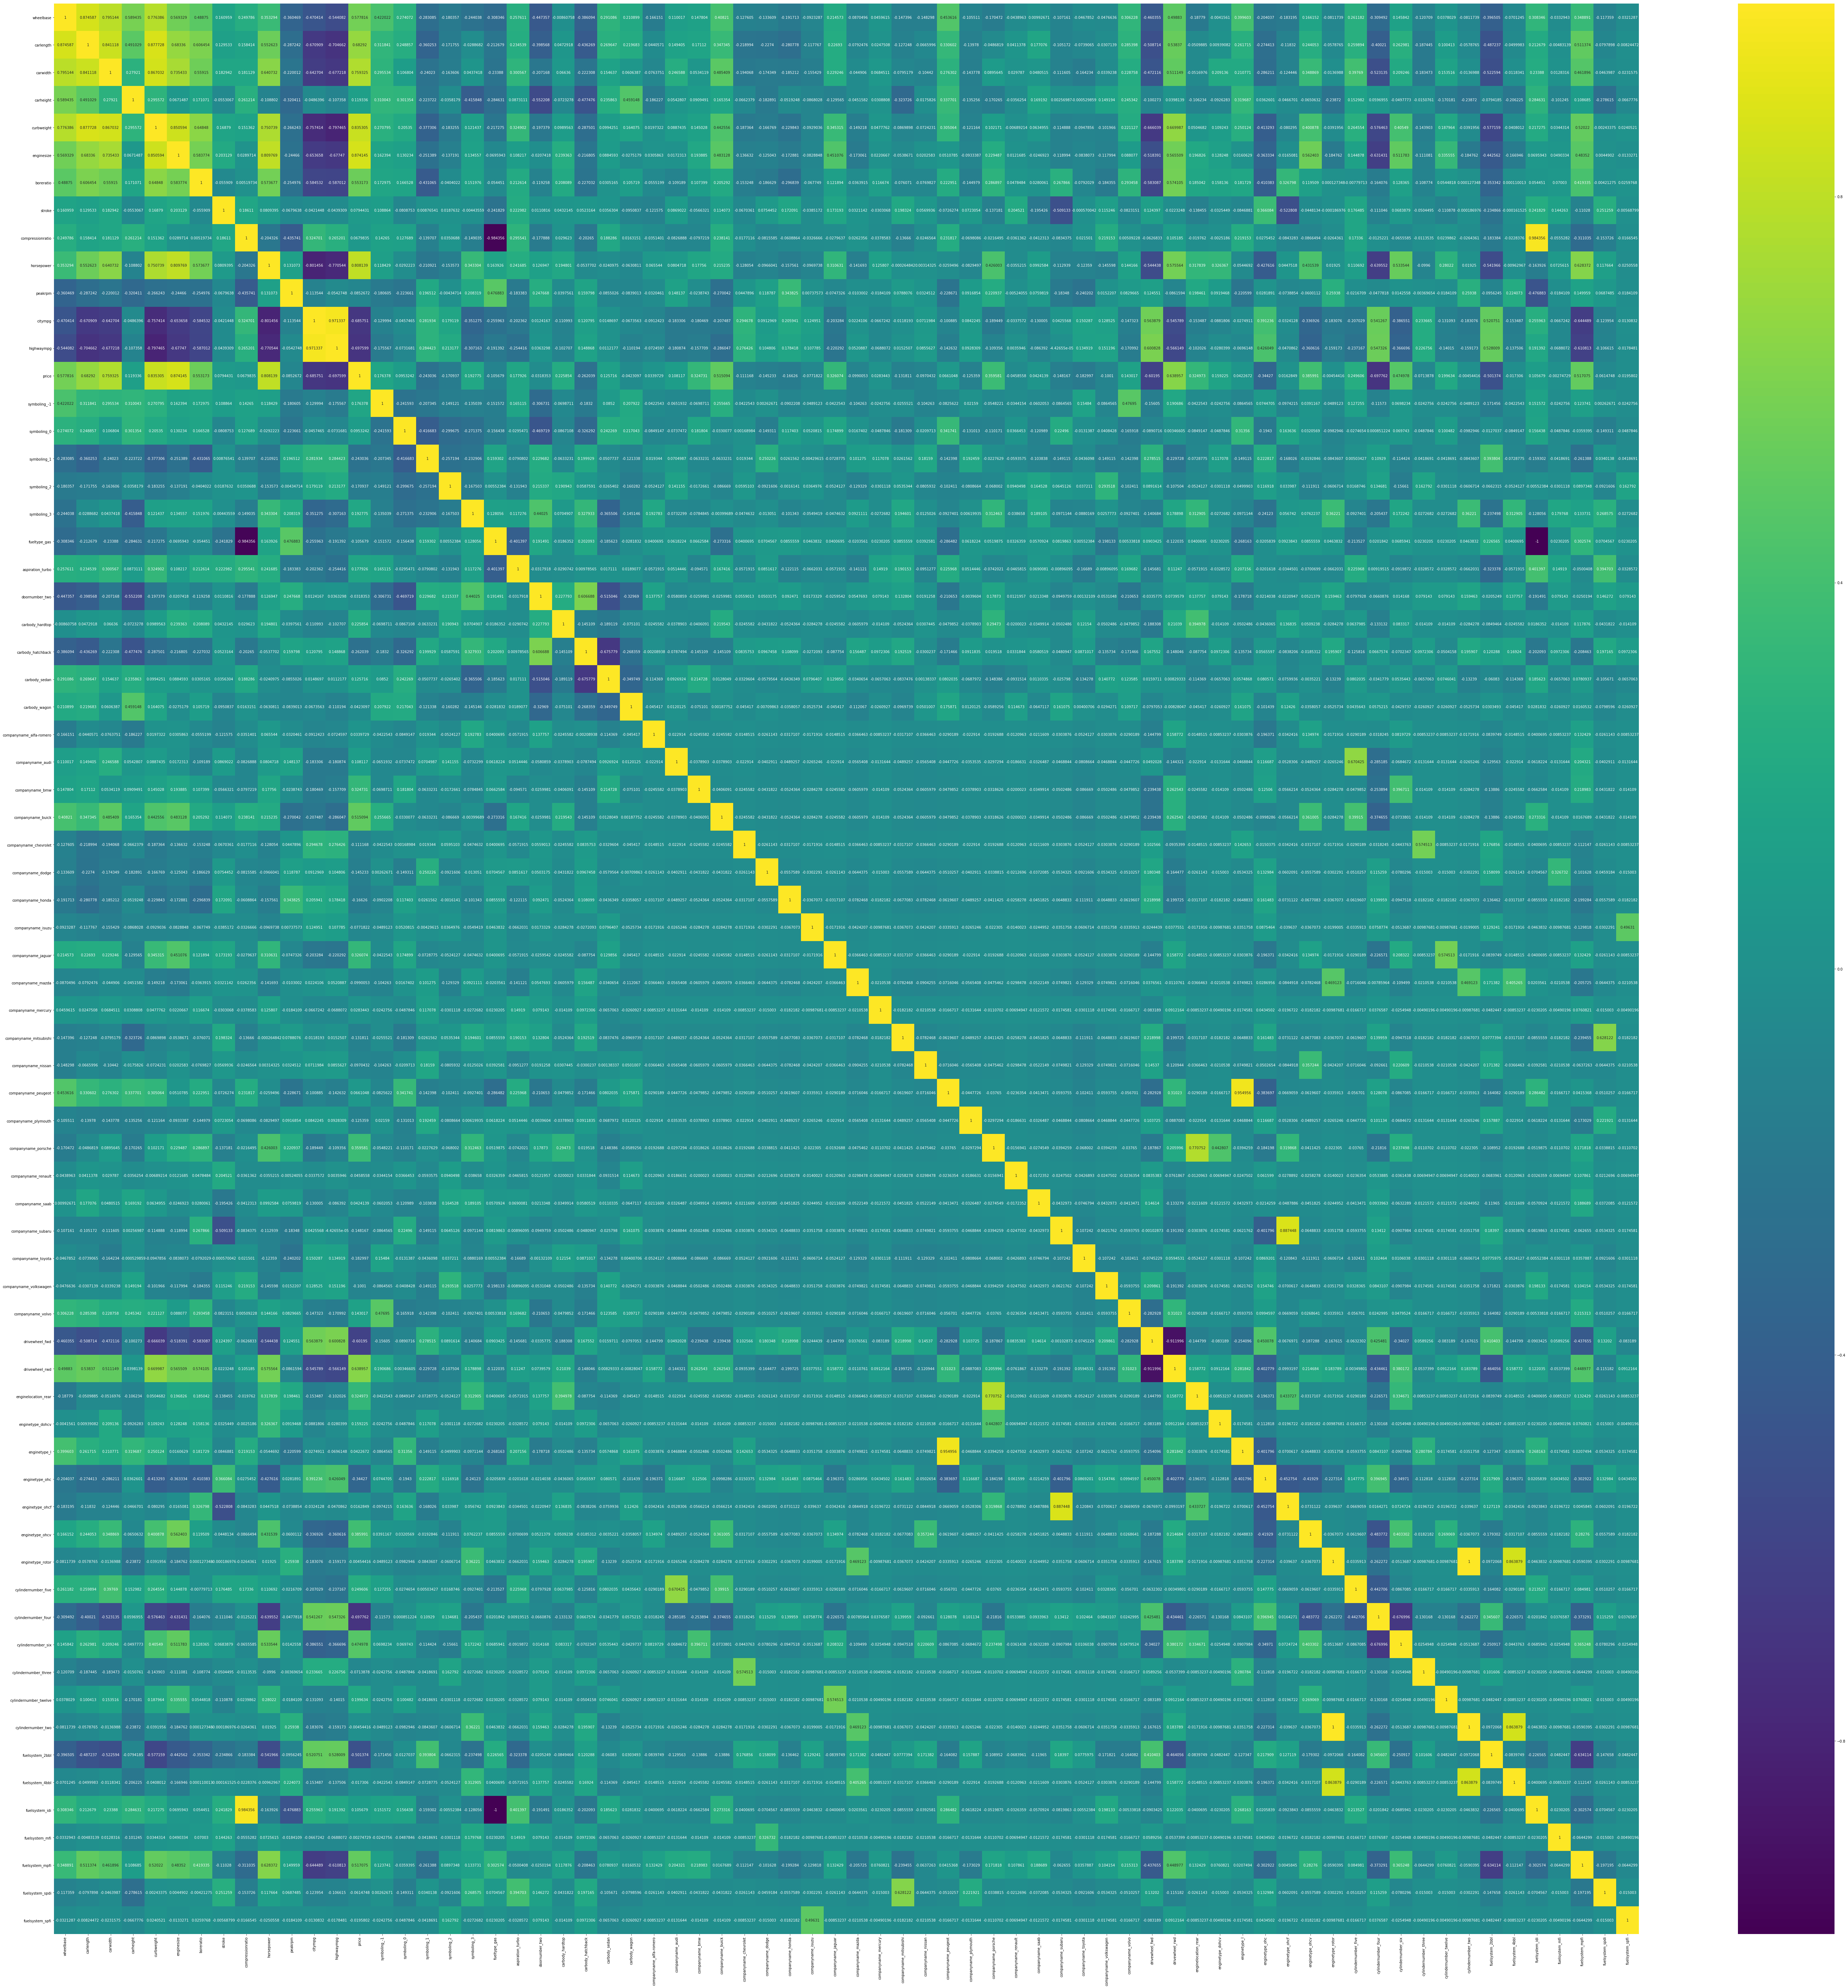

In [1293]:
# Correlation of all features with price column.
plt.figure(figsize=(100,100))
sns.heatmap(cars.corr(),annot=True,fmt="g", cmap='viridis')

## Splitting Dataset into train-test samples 

In [1237]:
# Using sklearn fuction to do a 80-20 split
df_train,df_test = train_test_split(cars,train_size=0.8,random_state=10)

In [1238]:
df_train.shape

(164, 70)

In [1239]:
df_train.head()

wheelbase  carlength  carwidth  carheight  curbweight  enginesize  \
160       95.7      166.3      64.4       53.0        2094          98   
98        95.1      162.4      63.8       53.3        2008          97   
127       89.5      168.9      65.0       51.6        2756         194   
47       113.0      199.6      69.6       52.8        4066         258   
91        94.5      165.3      63.8       54.5        1918          97   

     boreratio  stroke  compressionratio  horsepower  peakrpm  citympg  \
160       3.19    3.03               9.0          70     4800       38   
98        3.15    3.29               9.4          69     5200       31   
127       3.74    2.90               9.5         207     5900       17   
47        3.63    4.17               8.1         176     4750       15   
91        3.15    3.29               9.4          69     5200       31   

     highwaympg    price  symboling_-1  symboling_0  symboling_1  symboling_2  \
160          47   7738.0             0            1            0            0   
98           37   8249.0             0            0            0            1   
127          25  34028.0             0            0            0            0   
47           19  32250.0             0            1            0            0   
91           37   6649.0             0            0            1            0   

     symboling_3  fueltype_gas  aspiration_turbo  doornumber_two  \
160            0             1                 0               0   
98             0             1                 0               1   
127            1             1                 0               1   
47             0             1                 0               0   
91             0             1                 0               1   

     carbody_hardtop  carbody_hatchback  carbody_sedan  carbody_wagon  \
160                0                  0              1              0   
98                 1                  0              0              0   
127                1                  0              0              0   
47                 0                  0              1              0   
91                 0                  0              1              0   

     companyname_alfa-romero  companyname_audi  companyname_bmw  \
160                        0                 0                0   
98                         0                 0                0   
127                        0                 0                0   
47                         0                 0                0   
91                         0                 0                0   

     companyname_buick  companyname_chevrolet  companyname_dodge  \
160                  0                      0                  0   
98                   0                      0                  0   
127                  0                      0                  0   
47                   0                      0                  0   
91                   0                      0                  0   

     companyname_honda  companyname_isuzu  companyname_jaguar  \
160                  0                  0                   0   
98                   0                  0                   0   
127                  0                  0                   0   
47                   0                  0                   1   
91                   0                  0                   0   

     companyname_mazda  companyname_mercury  companyname_mitsubishi  \
160                  0                    0                       0   
98                   0                    0                       0   
127                  0                    0                       0   
47                   0                    0                       0   
91                   0                    0                       0   

     companyname_nissan  companyname_peugeot  companyname_plymouth  \
160                   0                    0                     0   
98        

In [1240]:
df_test.shape

(41, 70)

## Feature Scaling

In [1241]:
# Normalize the columns using a Min-Max scaler
scaler = MinMaxScaler()

# Use the min-max scaler object to fit the train data and transform the same.
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])

In [1242]:
df_train.head()

wheelbase  carlength  carwidth  carheight  curbweight  enginesize  \
160   0.265306   0.376119  0.350427   0.381818    0.235066    0.149798   
98    0.247813   0.317910  0.299145   0.409091    0.201707    0.145749   
127   0.084548   0.414925  0.401709   0.254545    0.491854    0.538462   
47    0.769679   0.873134  0.794872   0.363636    1.000000    0.797571   
91    0.230321   0.361194  0.299145   0.518182    0.166796    0.145749   

     boreratio    stroke  compressionratio  horsepower   peakrpm   citympg  \
160   0.464286  0.457143           0.12500    0.138365  0.265306  0.685714   
98    0.435714  0.580952           0.15000    0.132075  0.428571  0.485714   
127   0.857143  0.395238           0.15625    1.000000  0.714286  0.085714   
47    0.778571  1.000000           0.06875    0.805031  0.244898  0.028571   
91    0.435714  0.580952           0.15000    0.132075  0.428571  0.485714   

     highwaympg     price  symboling_-1  symboling_0  symboling_1  \
160    0.815789  0.065041             0            1            0   
98     0.552632  0.077727             0            0            0   
127    0.236842  0.717690             0            0            0   
47     0.078947  0.673551             0            1            0   
91     0.552632  0.038007             0            0            1   

     symboling_2  symboling_3  fueltype_gas  aspiration_turbo  doornumber_two  \
160            0            0             1                 0               0   
98             1            0             1                 0               1   
127            0            1             1                 0               1   
47             0            0             1                 0               0   
91             0            0             1                 0               1   

     carbody_hardtop  carbody_hatchback  carbody_sedan  carbody_wagon  \
160                0                  0              1              0   
98                 1                  0              0              0   
127                1                  0              0              0   
47                 0                  0              1              0   
91                 0                  0              1              0   

     companyname_alfa-romero  companyname_audi  companyname_bmw  \
160                        0                 0                0   
98                         0                 0                0   
127                        0                 0                0   
47                         0                 0                0   
91                         0                 0                0   

     companyname_buick  companyname_chevrolet  companyname_dodge  \
160                  0                      0                  0   
98                   0                      0                  0   
127                  0                      0                  0   
47                   0                      0                  0   
91                   0                      0                  0   

     companyname_honda  companyname_isuzu  companyname_jaguar  \
160                  0                  0                   0   
98                   0                  0                   0   
127                  0                  0                   0   
47                   0                  0                   1   
91                   0                  0                   0   

     companyname_mazda  companyname_mercury  companyname_mitsubishi  \
160                  0                    0                       0   
98                   0                    0                       0   
127                  0                    0                       0   
47                   0                    0                       0   
91                   0                    0                       0   

     companyname_nissan  companyname_peugeot  companyname_plymouth  \
160                   0                    0      

In [1243]:
# Create the X features dataframe after dropping the dependent price variable
X_train = df_train.drop('price',axis=1)

# Separate the price column 
y_train = df_train['price']
print(X_train.shape)
print(y_train.shape)

(164, 69)
(164,)


## Model  Building 

In [1244]:
# Creating a model with all variables
X_train_lm = sm.add_constant(X_train)
lr = sm.OLS(y_train,X_train_lm).fit()

In [1245]:
# Check the model summary
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     53.94
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           2.06e-57
Time:                        00:43:29   Log-Likelihood:                 312.60
No. Observations:                 164   AIC:                            -505.2
Df Residuals:                     104   BIC:                            -319.2
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0328      0.122      0.270      0.788      -0.208       0.274
wheelbase                   0.1786      0.092      1.934      0.056      -0.005       0.362
carlength                  -0.1824      0.096     -1.903      0.060      -0.373       0.008
carwidth                    0.1922      0.082      2.344      0.021       0.030       0.355
carheight                  -0.0495      0.046     -1.084      0.281      -0.140       0.041
curbweight                  0.4125      0.124      3.317      0.001       0.166       0.659
enginesize                  0.5344      0.179      2.990      0.003       0.180       0.889
boreratio                  -0.0678      0.075     -0.902      0.369      -0.217       0.081
stroke                     -0.1237      0.070     -1.780      0.078      -0.262       0.014
compressionratio           -0.2645      0.232     -1.139      0.258      -0.725       0.196
horsepower                  0.0432      0.112      0.388      0.699      -0.178       0.264
peakrpm                     0.1101      0.051      2.152      0.034       0.009       0.212
citympg                     0.0029      0.139      0.021      0.984      -0.273       0.279
highwaympg                  0.0712      0.134      0.530      0.597      -0.195       0.337
symboling_-1                0.0228      0.034      0.675      0.501      -0.044       0.090
symboling_0                 0.0466      0.042      1.122      0.264      -0.036       0.129
symboling_1                 0.0413      0.043      0.969      0.335      -0.043       0.126
symboling_2                 0.0367      0.045      0.810      0.420      -0.053       0.127
symboling_3                 0.0140      0.047      0.296      0.768      -0.080       0.108
fueltype_gas               -0.1087      0.073     -1.487      0.140      -0.254       0.036
aspiration_turbo            0.0292      0.024      1.217      0.226      -0.018       0.077
doornumber_two             -0.0058      0.014     -0.409      0.683      -0.034       0.022
carbody_hardtop            -0.0569      0.033     -1.709      0.090      -0.123       0.009
carbody_hatchback          -0.0912      0.031     -2.973      0.004      -0.152      -0.030
carbody_sedan              -0.0809      0.034     -2.411      0.018      -0.147      -0.014
carbody_wagon              -0.0977      0.037     -2.639      0.010      -0.171      -0.024
companyname_alfa-romero    -0.0094      0.090     -0.105      0.917      -0.187       0.168
companyname_audi            0.0840      0.066      1.266      0.208      -0.048       0.216
companyname_bmw             0.2290      0.063      3.635      0.000       0.104       0.354
companyname_buick           0.1147      0.077      1.498      0.137      -0.037       0.266
companyname_chevrolet       0.0601      0.049  

### Feature selection using RFE

In [1246]:
# Instantiate sklearn LinearRegression 
lr_model = LinearRegression()

# Instatiate RFE using the Linear Regression Object and find top - 20 relevant parameters
rfe = RFE(lr_model,20)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
  n_features_to_select=20, step=1, verbose=0)

In [1247]:
# Create a data frame to store features selected by RFE
rfe_imp = pd.DataFrame({'columns':X_train.columns,'relevant':rfe.support_,'ranking':rfe.ranking_})
rfe_imp[rfe_imp.ranking == 1]

columns  relevant  ranking
0               wheelbase      True        1
1               carlength      True        1
2                carwidth      True        1
4              curbweight      True        1
5              enginesize      True        1
6               boreratio      True        1
7                  stroke      True        1
9              horsepower      True        1
12             highwaympg      True        1
27        companyname_bmw      True        1
28      companyname_buick      True        1
29  companyname_chevrolet      True        1
33     companyname_jaguar      True        1
38    companyname_peugeot      True        1
40    companyname_porsche      True        1
43     companyname_subaru      True        1
49    enginelocation_rear      True        1
53        enginetype_ohcf      True        1
55       enginetype_rotor      True        1
58     cylindernumber_six      True        1

## Model -1 

In [1248]:
# Start modelling will all features having ranking as 1
sel_cols = X_train.columns[rfe.support_].tolist()

In [1249]:
# Create the features dataset using the selected features as per analysis
X_train = df_train[sel_cols]

# Add constant to the features for using stats models api
X_train = sm.add_constant(X_train)

# Fitting the data to the model
lr_sm1 = sm.OLS(y_train,X_train).fit()

# Summary of fitted model
lr_sm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     143.0
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           1.98e-83
Time:                        00:43:30   Log-Likelihood:                 274.53
No. Observations:                 164   AIC:                            -509.1
Df Residuals:                     144   BIC:                            -447.1
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0981      0.041     -2.404      0.017      -0.179      -0.017
wheelbase                 0.1000      0.058      1.714      0.089      -0.015       0.215
carlength                -0.0994      0.064     -1.559      0.121      -0.225       0.027
carwidth                  0.2556      0.057      4.481      0.000       0.143       0.368
curbweight                0.2642      0.078      3.397      0.001       0.110       0.418
enginesize                0.4242      0.090      4.714      0.000       0.246       0.602
boreratio                -0.0905      0.041     -2.208      0.029      -0.171      -0.009
stroke                   -0.1541      0.035     -4.348      0.000      -0.224      -0.084
horsepower                0.1955      0.052      3.729      0.000       0.092       0.299
highwaympg                0.0829      0.050      1.660      0.099      -0.016       0.182
companyname_bmw           0.2609      0.025     10.549      0.000       0.212       0.310
companyname_buick         0.1048      0.041      2.554      0.012       0.024       0.186
companyname_chevrolet     0.1072      0.053      2.028      0.044       0.003       0.212
companyname_jaguar        0.1653      0.048      3.439      0.001       0.070       0.260
companyname_peugeot      -0.0769      0.025     -3.074      0.003      -0.126      -0.027
companyname_porsche       0.1003      0.054      1.848      0.067      -0.007       0.207
companyname_subaru       -0.1296      0.027     -4.728      0.000      -0.184      -0.075
enginelocation_rear       0.2195      0.044      5.013      0.000       0.133       0.306
enginetype_ohcf           0.0899      0.022      4.065      0.000       0.046       0.134
enginetype_rotor          0.1247      0.040      3.083      0.002       0.045       0.205
cylindernumber_six       -0.0880      0.026     -3.430      0.001      -0.139      -0.037
==============================================================================
Omnibus:                       44.271   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.415
Skew:                           1.125   Prob(JB):                     1.06e-24
Kurtosis:                       6.331   Cond. No.                     3.07e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.88e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1250]:
# Checking Multicollinearity between features
# Create a Dataframe to store VIF values 
vif = pd.DataFrame()

# Remove constant from training dataset
X = X_train.drop('const',axis=1)

# create column to hold features
vif['features'] = X.columns

# Add VIF values into another column
vif['vifvalue'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['vifvalue'] = vif['vifvalue'].map(lambda x: round(x,2))

# Display the vif values in descending order
vif.sort_values('vifvalue',ascending=False)


features   vifvalue
17        enginetype_ohcf        inf
16    enginelocation_rear        inf
15     companyname_subaru        inf
3              curbweight  83.730000
1               carlength  74.530000
2                carwidth  56.890000
4              enginesize  52.420000
5               boreratio  41.160000
0               wheelbase  36.220000
7              horsepower  27.450000
6                  stroke  24.970000
8              highwaympg  11.530000
14    companyname_porsche   5.020000
19     cylindernumber_six   5.020000
10      companyname_buick   4.300000
13    companyname_peugeot   2.130000
12     companyname_jaguar   1.940000
9         companyname_bmw   1.820000
18       enginetype_rotor   1.350000
11  companyname_chevrolet   1.180000

## Model 2 

In [1251]:
# enginetype_ohcf variable has inf VIF. Hence it is completely explained by other variables and can be dropped.
sel_cols.remove('enginetype_ohcf')
sel_cols

['wheelbase',
 'carlength',
 'carwidth',
 'curbweight',
 'enginesize',
 'boreratio',
 'stroke',
 'horsepower',
 'highwaympg',
 'companyname_bmw',
 'companyname_buick',
 'companyname_chevrolet',
 'companyname_jaguar',
 'companyname_peugeot',
 'companyname_porsche',
 'companyname_subaru',
 'enginelocation_rear',
 'enginetype_rotor',
 'cylindernumber_six']

In [1252]:
# Create the features dataset using the selected features as per analysis
X_train = df_train[sel_cols]

# Add constant to the features for using stats models api
X_train = sm.add_constant(X_train)

# Fitting the data to the model
lr_sm2 = sm.OLS(y_train,X_train).fit()

# Summary of fitted model
lr_sm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     143.0
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           1.98e-83
Time:                        00:43:30   Log-Likelihood:                 274.53
No. Observations:                 164   AIC:                            -509.1
Df Residuals:                     144   BIC:                            -447.1
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0981      0.041     -2.404      0.017      -0.179      -0.017
wheelbase                 0.1000      0.058      1.714      0.089      -0.015       0.215
carlength                -0.0994      0.064     -1.559      0.121      -0.225       0.027
carwidth                  0.2556      0.057      4.481      0.000       0.143       0.368
curbweight                0.2642      0.078      3.397      0.001       0.110       0.418
enginesize                0.4242      0.090      4.714      0.000       0.246       0.602
boreratio                -0.0905      0.041     -2.208      0.029      -0.171      -0.009
stroke                   -0.1541      0.035     -4.348      0.000      -0.224      -0.084
horsepower                0.1955      0.052      3.729      0.000       0.092       0.299
highwaympg                0.0829      0.050      1.660      0.099      -0.016       0.182
companyname_bmw           0.2609      0.025     10.549      0.000       0.212       0.310
companyname_buick         0.1048      0.041      2.554      0.012       0.024       0.186
companyname_chevrolet     0.1072      0.053      2.028      0.044       0.003       0.212
companyname_jaguar        0.1653      0.048      3.439      0.001       0.070       0.260
companyname_peugeot      -0.0769      0.025     -3.074      0.003      -0.126      -0.027
companyname_porsche       0.1003      0.054      1.848      0.067      -0.007       0.207
companyname_subaru       -0.0397      0.024     -1.670      0.097      -0.087       0.007
enginelocation_rear       0.3094      0.064      4.855      0.000       0.183       0.435
enginetype_rotor          0.1247      0.040      3.083      0.002       0.045       0.205
cylindernumber_six       -0.0880      0.026     -3.430      0.001      -0.139      -0.037
==============================================================================
Omnibus:                       44.271   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.415
Skew:                           1.125   Prob(JB):                     1.06e-24
Kurtosis:                       6.331   Cond. No.                         45.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1154]:
# Checking Multicollinearity between features
# Create a Dataframe to store VIF values 
vif = pd.DataFrame()

# Remove constant from training dataset
X = X_train.drop('const',axis=1)

# create column to hold features
vif['features'] = X.columns

# Add VIF values into another column
vif['vifvalue'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['vifvalue'] = vif['vifvalue'].map(lambda x: round(x,2))

# Display the vif values in descending order
vif.sort_values('vifvalue',ascending=False)

features  vifvalue
3              curbweight     83.73
1               carlength     74.53
2                carwidth     56.89
4              enginesize     52.42
5               boreratio     41.16
0               wheelbase     36.22
7              horsepower     27.45
6                  stroke     24.97
8              highwaympg     11.53
16    enginelocation_rear      5.20
14    companyname_porsche      5.02
18     cylindernumber_six      5.02
10      companyname_buick      4.30
15     companyname_subaru      2.35
13    companyname_peugeot      2.13
12     companyname_jaguar      1.94
9         companyname_bmw      1.82
17       enginetype_rotor      1.35
11  companyname_chevrolet      1.18

## Model 3

In [1266]:
# carlength variable has high VIF. Hence it has higher degree of correlation with other columns. Hence dropping
sel_cols.remove('carlength')
sel_cols

['wheelbase',
 'carwidth',
 'curbweight',
 'enginesize',
 'boreratio',
 'stroke',
 'horsepower',
 'highwaympg',
 'companyname_bmw',
 'companyname_buick',
 'companyname_chevrolet',
 'companyname_jaguar',
 'companyname_peugeot',
 'companyname_porsche',
 'companyname_subaru',
 'enginelocation_rear',
 'enginetype_rotor',
 'cylindernumber_six']

In [1267]:
# Create the features dataset using the selected features as per analysis
X_train = df_train[sel_cols]

# Add constant to the features for using stats models api
X_train = sm.add_constant(X_train)

# Fitting the data to the model
lr_sm3 = sm.OLS(y_train,X_train).fit()

# Summary of fitted model
lr_sm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     149.3
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           5.28e-84
Time:                        00:49:57   Log-Likelihood:                 273.16
No. Observations:                 164   AIC:                            -508.3
Df Residuals:                     145   BIC:                            -449.4
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.1080      0.040     -2.667      0.009      -0.188      -0.028
wheelbase                 0.0549      0.051      1.077      0.283      -0.046       0.155
carwidth                  0.2352      0.056      4.216      0.000       0.125       0.346
curbweight                0.2152      0.071      3.010      0.003       0.074       0.357
enginesize                0.4257      0.090      4.709      0.000       0.247       0.604
boreratio                -0.0985      0.041     -2.413      0.017      -0.179      -0.018
stroke                   -0.1439      0.035     -4.112      0.000      -0.213      -0.075
horsepower                0.2013      0.053      3.830      0.000       0.097       0.305
highwaympg                0.0861      0.050      1.715      0.088      -0.013       0.185
companyname_bmw           0.2574      0.025     10.399      0.000       0.208       0.306
companyname_buick         0.1212      0.040      3.042      0.003       0.042       0.200
companyname_chevrolet     0.1140      0.053      2.152      0.033       0.009       0.219
companyname_jaguar        0.1732      0.048      3.605      0.000       0.078       0.268
companyname_peugeot      -0.0657      0.024     -2.730      0.007      -0.113      -0.018
companyname_porsche       0.1159      0.054      2.163      0.032       0.010       0.222
companyname_subaru       -0.0336      0.024     -1.426      0.156      -0.080       0.013
enginelocation_rear       0.2893      0.063      4.612      0.000       0.165       0.413
enginetype_rotor          0.1274      0.041      3.135      0.002       0.047       0.208
cylindernumber_six       -0.0828      0.026     -3.241      0.001      -0.133      -0.032
==============================================================================
Omnibus:                       42.220   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.512
Skew:                           1.091   Prob(JB):                     1.49e-22
Kurtosis:                       6.154   Cond. No.                         43.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1268]:
# Checking Multicollinearity between features
# Create a Dataframe to store VIF values 
vif = pd.DataFrame()

# Remove constant from training dataset
X = X_train.drop('const',axis=1)

# create column to hold features
vif['features'] = X.columns

# Add VIF values into another column
vif['vifvalue'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['vifvalue'] = vif['vifvalue'].map(lambda x: round(x,2))

# Display the vif values in descending order
vif.sort_values('vifvalue',ascending=False)

features  vifvalue
2              curbweight     67.68
1                carwidth     53.66
3              enginesize     52.36
4               boreratio     40.37
6              horsepower     27.45
0               wheelbase     26.96
5                  stroke     24.52
7              highwaympg     11.29
15    enginelocation_rear      4.98
17     cylindernumber_six      4.92
13    companyname_porsche      4.84
9       companyname_buick      4.02
14     companyname_subaru      2.32
12    companyname_peugeot      1.96
11     companyname_jaguar      1.90
8         companyname_bmw      1.80
16       enginetype_rotor      1.35
10  companyname_chevrolet      1.17

## Model - 4 

In [1269]:
# carwidth variable has 35.81 VIF. Hence it has higher degree of correlation with other columns. Hence dropping
sel_cols.remove('carwidth')
sel_cols

['wheelbase',
 'curbweight',
 'enginesize',
 'boreratio',
 'stroke',
 'horsepower',
 'highwaympg',
 'companyname_bmw',
 'companyname_buick',
 'companyname_chevrolet',
 'companyname_jaguar',
 'companyname_peugeot',
 'companyname_porsche',
 'companyname_subaru',
 'enginelocation_rear',
 'enginetype_rotor',
 'cylindernumber_six']

In [1270]:
# Create the features dataset using the selected features as per analysis
X_train = df_train[sel_cols]

# Add constant to the features for using stats models api
X_train = sm.add_constant(X_train)

# Fitting the data to the model
lr_sm4 = sm.OLS(y_train,X_train).fit()

# Summary of fitted model
lr_sm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     140.9
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           1.81e-81
Time:                        00:50:30   Log-Likelihood:                 263.68
No. Observations:                 164   AIC:                            -491.4
Df Residuals:                     146   BIC:                            -435.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0942      0.043     -2.211      0.029      -0.178      -0.010
wheelbase                 0.1521      0.048      3.174      0.002       0.057       0.247
curbweight                0.3162      0.071      4.446      0.000       0.176       0.457
enginesize                0.4625      0.095      4.868      0.000       0.275       0.650
boreratio                -0.1291      0.042     -3.042      0.003      -0.213      -0.045
stroke                   -0.1342      0.037     -3.638      0.000      -0.207      -0.061
horsepower                0.2464      0.054      4.537      0.000       0.139       0.354
highwaympg                0.1098      0.053      2.087      0.039       0.006       0.214
companyname_bmw           0.2394      0.026      9.301      0.000       0.189       0.290
companyname_buick         0.1296      0.042      3.084      0.002       0.047       0.213
companyname_chevrolet     0.0756      0.055      1.372      0.172      -0.033       0.184
companyname_jaguar        0.1275      0.049      2.580      0.011       0.030       0.225
companyname_peugeot      -0.0638      0.025     -2.510      0.013      -0.114      -0.014
companyname_porsche       0.1685      0.055      3.063      0.003       0.060       0.277
companyname_subaru       -0.0192      0.025     -0.782      0.436      -0.068       0.029
enginelocation_rear       0.2212      0.064      3.456      0.001       0.095       0.348
enginetype_rotor          0.1534      0.042      3.619      0.000       0.070       0.237
cylindernumber_six       -0.0933      0.027     -3.475      0.001      -0.146      -0.040
==============================================================================
Omnibus:                       31.729   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.286
Skew:                           0.899   Prob(JB):                     4.92e-14
Kurtosis:                       5.395   Cond. No.                         41.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1271]:
# Checking Multicollinearity between features
# Create a Dataframe to store VIF values 
vif = pd.DataFrame()

# Remove constant from training dataset
X = X_train.drop('const',axis=1)

# create column to hold features
vif['features'] = X.columns

# Add VIF values into another column
vif['vifvalue'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['vifvalue'] = vif['vifvalue'].map(lambda x: round(x,2))

# Display the vif values in descending order
vif.sort_values('vifvalue',ascending=False)

features  vifvalue
1              curbweight     58.63
2              enginesize     51.97
3               boreratio     39.18
5              horsepower     25.62
4                  stroke     24.25
0               wheelbase     21.09
6              highwaympg     10.25
16     cylindernumber_six      4.86
14    enginelocation_rear      4.65
12    companyname_porsche      4.59
8       companyname_buick      4.01
13     companyname_subaru      2.24
11    companyname_peugeot      1.96
10     companyname_jaguar      1.79
7         companyname_bmw      1.75
15       enginetype_rotor      1.31
9   companyname_chevrolet      1.13

## Model 5

In [1272]:
# companyname_subaru has high p value hence insignificant
sel_cols.remove('companyname_subaru')
sel_cols

['wheelbase',
 'curbweight',
 'enginesize',
 'boreratio',
 'stroke',
 'horsepower',
 'highwaympg',
 'companyname_bmw',
 'companyname_buick',
 'companyname_chevrolet',
 'companyname_jaguar',
 'companyname_peugeot',
 'companyname_porsche',
 'enginelocation_rear',
 'enginetype_rotor',
 'cylindernumber_six']

In [1273]:
# Create the features dataset using the selected features as per analysis
X_train = df_train[sel_cols]

# Add constant to the features for using stats models api
X_train = sm.add_constant(X_train)

# Fitting the data to the model
lr_sm5 = sm.OLS(y_train,X_train).fit()

# Summary of fitted model
lr_sm5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     150.0
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           1.97e-82
Time:                        00:51:06   Log-Likelihood:                 263.34
No. Observations:                 164   AIC:                            -492.7
Df Residuals:                     147   BIC:                            -440.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.1052      0.040     -2.620      0.010      -0.185      -0.026
wheelbase                 0.1593      0.047      3.390      0.001       0.066       0.252
curbweight                0.3236      0.070      4.597      0.000       0.185       0.463
enginesize                0.4684      0.095      4.951      0.000       0.281       0.655
boreratio                -0.1475      0.035     -4.179      0.000      -0.217      -0.078
stroke                   -0.1199      0.032     -3.745      0.000      -0.183      -0.057
horsepower                0.2537      0.053      4.748      0.000       0.148       0.359
highwaympg                0.1170      0.052      2.259      0.025       0.015       0.219
companyname_bmw           0.2412      0.026      9.419      0.000       0.191       0.292
companyname_buick         0.1248      0.042      3.007      0.003       0.043       0.207
companyname_chevrolet     0.0776      0.055      1.413      0.160      -0.031       0.186
companyname_jaguar        0.1181      0.048      2.467      0.015       0.023       0.213
companyname_peugeot      -0.0620      0.025     -2.451      0.015      -0.112      -0.012
companyname_porsche       0.1769      0.054      3.284      0.001       0.070       0.283
enginelocation_rear       0.2210      0.064      3.458      0.001       0.095       0.347
enginetype_rotor          0.1584      0.042      3.786      0.000       0.076       0.241
cylindernumber_six       -0.0968      0.026     -3.663      0.000      -0.149      -0.045
==============================================================================
Omnibus:                       30.572   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.202
Skew:                           0.889   Prob(JB):                     6.25e-13
Kurtosis:                       5.251   Cond. No.                         41.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1274]:
# Checking Multicollinearity between features
# Create a Dataframe to store VIF values 
vif = pd.DataFrame()

# Remove constant from training dataset
X = X_train.drop('const',axis=1)

# create column to hold features
vif['features'] = X.columns

# Add VIF values into another column
vif['vifvalue'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['vifvalue'] = vif['vifvalue'].map(lambda x: round(x,2))

# Display the vif values in descending order
vif.sort_values('vifvalue',ascending=False)

features  vifvalue
1              curbweight     58.51
2              enginesize     51.02
5              horsepower     25.59
3               boreratio     24.35
0               wheelbase     20.64
4                  stroke     19.96
6              highwaympg      9.89
15     cylindernumber_six      4.77
13    enginelocation_rear      4.65
12    companyname_porsche      4.38
8       companyname_buick      3.92
11    companyname_peugeot      1.94
7         companyname_bmw      1.74
10     companyname_jaguar      1.72
14       enginetype_rotor      1.30
9   companyname_chevrolet      1.12

## Model 6

In [1275]:
# companyname_chevrolet has high p-value hence insignificant. Dropping the same. Dropping car names are they are lesser 
# important from business perspective for variables interpretation of price
sel_cols.remove('companyname_chevrolet')
sel_cols

['wheelbase',
 'curbweight',
 'enginesize',
 'boreratio',
 'stroke',
 'horsepower',
 'highwaympg',
 'companyname_bmw',
 'companyname_buick',
 'companyname_jaguar',
 'companyname_peugeot',
 'companyname_porsche',
 'enginelocation_rear',
 'enginetype_rotor',
 'cylindernumber_six']

In [1276]:
# Create the features dataset using the selected features as per analysis
X_train = df_train[sel_cols]

# Add constant to the features for using stats models api
X_train = sm.add_constant(X_train)

# Fitting the data to the model
lr_sm6 = sm.OLS(y_train,X_train).fit()

# Summary of fitted model
lr_sm6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     158.8
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           4.10e-83
Time:                        00:51:51   Log-Likelihood:                 262.23
No. Observations:                 164   AIC:                            -492.5
Df Residuals:                     148   BIC:                            -442.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1143      0.040     -2.875      0.005      -0.193      -0.036
wheelbase               0.1588      0.047      3.368      0.001       0.066       0.252
curbweight              0.3217      0.071      4.555      0.000       0.182       0.461
enginesize              0.4557      0.094      4.823      0.000       0.269       0.642
boreratio              -0.1446      0.035     -4.089      0.000      -0.214      -0.075
stroke                 -0.1223      0.032     -3.811      0.000      -0.186      -0.059
horsepower              0.2686      0.053      5.108      0.000       0.165       0.372
highwaympg              0.1369      0.050      2.738      0.007       0.038       0.236
companyname_bmw         0.2421      0.026      9.426      0.000       0.191       0.293
companyname_buick       0.1325      0.041      3.210      0.002       0.051       0.214
companyname_jaguar      0.1248      0.048      2.612      0.010       0.030       0.219
companyname_peugeot    -0.0585      0.025     -2.317      0.022      -0.108      -0.009
companyname_porsche     0.1753      0.054      3.244      0.001       0.069       0.282
enginelocation_rear     0.2170      0.064      3.388      0.001       0.090       0.344
enginetype_rotor        0.1599      0.042      3.808      0.000       0.077       0.243
cylindernumber_six     -0.0955      0.027     -3.603      0.000      -0.148      -0.043
==============================================================================
Omnibus:                       31.112   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.718
Skew:                           0.916   Prob(JB):                     7.96e-13
Kurtosis:                       5.190   Cond. No.                         40.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1277]:
# Checking Multicollinearity between features
# Create a Dataframe to store VIF values 
vif = pd.DataFrame()

# Remove constant from training dataset
X = X_train.drop('const',axis=1)

# create column to hold features
vif['features'] = X.columns

# Add VIF values into another column
vif['vifvalue'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['vifvalue'] = vif['vifvalue'].map(lambda x: round(x,2))

# Display the vif values in descending order
vif.sort_values('vifvalue',ascending=False)

features  vifvalue
1            curbweight     58.28
2            enginesize     50.79
5            horsepower     25.04
3             boreratio     24.35
0             wheelbase     20.63
4                stroke     19.76
6            highwaympg      9.27
14   cylindernumber_six      4.76
12  enginelocation_rear      4.64
11  companyname_porsche      4.38
8     companyname_buick      3.86
10  companyname_peugeot      1.92
7       companyname_bmw      1.74
9    companyname_jaguar      1.70
13     enginetype_rotor      1.30

## Model 7

In [1278]:
# High VIF
sel_cols.remove('curbweight')
sel_cols

['wheelbase',
 'enginesize',
 'boreratio',
 'stroke',
 'horsepower',
 'highwaympg',
 'companyname_bmw',
 'companyname_buick',
 'companyname_jaguar',
 'companyname_peugeot',
 'companyname_porsche',
 'enginelocation_rear',
 'enginetype_rotor',
 'cylindernumber_six']

In [1279]:
# Create the features dataset using the selected features as per analysis
X_train = df_train[sel_cols]

# Add constant to the features for using stats models api
X_train = sm.add_constant(X_train)

# Fitting the data to the model
lr_sm7 = sm.OLS(y_train,X_train).fit()

# Summary of fitted model
lr_sm7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     148.9
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           5.13e-80
Time:                        00:52:47   Log-Likelihood:                 251.47
No. Observations:                 164   AIC:                            -472.9
Df Residuals:                     149   BIC:                            -426.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0672      0.041     -1.644      0.102      -0.148       0.014
wheelbase               0.2651      0.044      6.081      0.000       0.179       0.351
enginesize              0.5430      0.098      5.514      0.000       0.348       0.738
boreratio              -0.1203      0.037     -3.235      0.002      -0.194      -0.047
stroke                 -0.1140      0.034     -3.343      0.001      -0.181      -0.047
horsepower              0.3422      0.053      6.428      0.000       0.237       0.447
highwaympg              0.0766      0.051      1.494      0.137      -0.025       0.178
companyname_bmw         0.2298      0.027      8.452      0.000       0.176       0.284
companyname_buick       0.1543      0.044      3.534      0.001       0.068       0.241
companyname_jaguar      0.1536      0.050      3.048      0.003       0.054       0.253
companyname_peugeot    -0.0181      0.025     -0.718      0.474      -0.068       0.032
companyname_porsche     0.1779      0.058      3.094      0.002       0.064       0.292
enginelocation_rear     0.1753      0.067      2.598      0.010       0.042       0.309
enginetype_rotor        0.1624      0.045      3.635      0.000       0.074       0.251
cylindernumber_six     -0.0829      0.028     -2.954      0.004      -0.138      -0.027
==============================================================================
Omnibus:                       30.115   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.225
Skew:                           0.903   Prob(JB):                     4.56e-12
Kurtosis:                       5.093   Cond. No.                         38.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1280]:
# Checking Multicollinearity between features
# Create a Dataframe to store VIF values 
vif = pd.DataFrame()

# Remove constant from training dataset
X = X_train.drop('const',axis=1)

# create column to hold features
vif['features'] = X.columns

# Add VIF values into another column
vif['vifvalue'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['vifvalue'] = vif['vifvalue'].map(lambda x: round(x,2))

# Display the vif values in descending order
vif.sort_values('vifvalue',ascending=False)

features  vifvalue
1            enginesize     49.38
2             boreratio     22.73
4            horsepower     19.90
3                stroke     19.36
0             wheelbase     14.43
5            highwaympg      9.19
13   cylindernumber_six      4.72
11  enginelocation_rear      4.55
10  companyname_porsche      4.38
7     companyname_buick      3.80
6       companyname_bmw      1.72
8    companyname_jaguar      1.68
9   companyname_peugeot      1.68
12     enginetype_rotor      1.29

## Model 8

In [1281]:
# High p value
sel_cols.remove('companyname_peugeot')
sel_cols

['wheelbase',
 'enginesize',
 'boreratio',
 'stroke',
 'horsepower',
 'highwaympg',
 'companyname_bmw',
 'companyname_buick',
 'companyname_jaguar',
 'companyname_porsche',
 'enginelocation_rear',
 'enginetype_rotor',
 'cylindernumber_six']

In [1282]:
# Create the features dataset using the selected features as per analysis
X_train = df_train[sel_cols]

# Add constant to the features for using stats models api
X_train = sm.add_constant(X_train)

# Fitting the data to the model
lr_sm8 = sm.OLS(y_train,X_train).fit()

# Summary of fitted model
lr_sm8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     160.9
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           5.12e-81
Time:                        00:53:29   Log-Likelihood:                 251.19
No. Observations:                 164   AIC:                            -474.4
Df Residuals:                     150   BIC:                            -431.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0684      0.041     -1.677      0.096      -0.149       0.012
wheelbase               0.2500      0.038      6.556      0.000       0.175       0.325
enginesize              0.5400      0.098      5.497      0.000       0.346       0.734
boreratio              -0.1196      0.037     -3.223      0.002      -0.193      -0.046
stroke                 -0.1121      0.034     -3.304      0.001      -0.179      -0.045
horsepower              0.3505      0.052      6.754      0.000       0.248       0.453
highwaympg              0.0813      0.051      1.599      0.112      -0.019       0.182
companyname_bmw         0.2320      0.027      8.603      0.000       0.179       0.285
companyname_buick       0.1605      0.043      3.756      0.000       0.076       0.245
companyname_jaguar      0.1592      0.050      3.201      0.002       0.061       0.257
companyname_porsche     0.1758      0.057      3.066      0.003       0.063       0.289
enginelocation_rear     0.1705      0.067      2.544      0.012       0.038       0.303
enginetype_rotor        0.1625      0.045      3.643      0.000       0.074       0.251
cylindernumber_six     -0.0826      0.028     -2.950      0.004      -0.138      -0.027
==============================================================================
Omnibus:                       31.525   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.306
Skew:                           0.938   Prob(JB):                     9.78e-13
Kurtosis:                       5.139   Cond. No.                         38.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1283]:
# Checking Multicollinearity between features
# Create a Dataframe to store VIF values 
vif = pd.DataFrame()

# Remove constant from training dataset
X = X_train.drop('const',axis=1)

# create column to hold features
vif['features'] = X.columns

# Add VIF values into another column
vif['vifvalue'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['vifvalue'] = vif['vifvalue'].map(lambda x: round(x,2))

# Display the vif values in descending order
vif.sort_values('vifvalue',ascending=False)

features  vifvalue
1            enginesize     49.31
2             boreratio     22.73
3                stroke     19.28
4            horsepower     18.88
0             wheelbase     10.58
5            highwaympg      8.96
12   cylindernumber_six      4.71
10  enginelocation_rear      4.51
9   companyname_porsche      4.37
7     companyname_buick      3.66
6       companyname_bmw      1.70
8    companyname_jaguar      1.64
11     enginetype_rotor      1.29

## Model 9

In [1284]:
# High p-value
sel_cols.remove('highwaympg')
sel_cols

['wheelbase',
 'enginesize',
 'boreratio',
 'stroke',
 'horsepower',
 'companyname_bmw',
 'companyname_buick',
 'companyname_jaguar',
 'companyname_porsche',
 'enginelocation_rear',
 'enginetype_rotor',
 'cylindernumber_six']

In [1285]:
# Create the features dataset using the selected features as per analysis
X_train = df_train[sel_cols]

# Add constant to the features for using stats models api
X_train = sm.add_constant(X_train)

# Fitting the data to the model
lr_sm = sm.OLS(y_train,X_train).fit()

# Summary of fitted model
lr_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     172.3
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           1.34e-81
Time:                        00:54:00   Log-Likelihood:                 249.80
No. Observations:                 164   AIC:                            -473.6
Df Residuals:                     151   BIC:                            -433.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0154      0.024     -0.644      0.521      -0.063       0.032
wheelbase               0.2321      0.037      6.335      0.000       0.160       0.304
enginesize              0.5363      0.099      5.433      0.000       0.341       0.731
boreratio              -0.1242      0.037     -3.340      0.001      -0.198      -0.051
stroke                 -0.1019      0.034     -3.041      0.003      -0.168      -0.036
horsepower              0.2974      0.040      7.414      0.000       0.218       0.377
companyname_bmw         0.2315      0.027      8.541      0.000       0.178       0.285
companyname_buick       0.1629      0.043      3.797      0.000       0.078       0.248
companyname_jaguar      0.1577      0.050      3.156      0.002       0.059       0.256
companyname_porsche     0.1830      0.057      3.185      0.002       0.069       0.297
enginelocation_rear     0.1784      0.067      2.655      0.009       0.046       0.311
enginetype_rotor        0.1436      0.043      3.321      0.001       0.058       0.229
cylindernumber_six     -0.0750      0.028     -2.704      0.008      -0.130      -0.020
==============================================================================
Omnibus:                       33.168   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.652
Skew:                           0.973   Prob(JB):                     1.11e-13
Kurtosis:                       5.224   Cond. No.                         37.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1286]:
# Checking Multicollinearity between features
# Create a Dataframe to store VIF values 
vif = pd.DataFrame()

# Remove constant from training dataset
X = X_train.drop('const',axis=1)

# create column to hold features
vif['features'] = X.columns

# Add VIF values into another column
vif['vifvalue'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['vifvalue'] = vif['vifvalue'].map(lambda x: round(x,2))

# Display the vif values in descending order
vif.sort_values('vifvalue',ascending=False)

features  vifvalue
1            enginesize     47.11
2             boreratio     18.49
4            horsepower     14.85
0             wheelbase     10.58
3                stroke      7.16
9   enginelocation_rear      4.44
11   cylindernumber_six      4.43
8   companyname_porsche      4.36
6     companyname_buick      3.61
5       companyname_bmw      1.70
7    companyname_jaguar      1.59
10     enginetype_rotor      1.23

## Model 10

In [1287]:
# High vif
sel_cols.remove('boreratio')
sel_cols

['wheelbase',
 'enginesize',
 'stroke',
 'horsepower',
 'companyname_bmw',
 'companyname_buick',
 'companyname_jaguar',
 'companyname_porsche',
 'enginelocation_rear',
 'enginetype_rotor',
 'cylindernumber_six']

In [1288]:
# Create the features dataset using the selected features as per analysis
X_train = df_train[sel_cols]

# Add constant to the features for using stats models api
X_train = sm.add_constant(X_train)

# Fitting the data to the model
lr_sm10 = sm.OLS(y_train,X_train).fit()

# Summary of fitted model
lr_sm10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     175.2
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           2.09e-80
Time:                        00:55:15   Log-Likelihood:                 243.96
No. Observations:                 164   AIC:                            -463.9
Df Residuals:                     152   BIC:                            -426.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0590      0.021     -2.864      0.005      -0.100      -0.018
wheelbase               0.2094      0.037      5.632      0.000       0.136       0.283
enginesize              0.3808      0.090      4.236      0.000       0.203       0.558
stroke                 -0.0636      0.033     -1.956      0.052      -0.128       0.001
horsepower              0.2824      0.041      6.858      0.000       0.201       0.364
companyname_bmw         0.2298      0.028      8.210      0.000       0.174       0.285
companyname_buick       0.2268      0.040      5.714      0.000       0.148       0.305
companyname_jaguar      0.1802      0.051      3.524      0.001       0.079       0.281
companyname_porsche     0.1544      0.059      2.630      0.009       0.038       0.270
enginelocation_rear     0.1901      0.069      2.743      0.007       0.053       0.327
enginetype_rotor        0.1120      0.044      2.570      0.011       0.026       0.198
cylindernumber_six     -0.0353      0.026     -1.364      0.175      -0.086       0.016
==============================================================================
Omnibus:                       31.298   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.341
Skew:                           0.946   Prob(JB):                     2.61e-12
Kurtosis:                       5.056   Cond. No.                         30.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1289]:
# Checking Multicollinearity between features
# Create a Dataframe to store VIF values 
vif = pd.DataFrame()

# Remove constant from training dataset
X = X_train.drop('const',axis=1)

# create column to hold features
vif['features'] = X.columns

# Add VIF values into another column
vif['vifvalue'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['vifvalue'] = vif['vifvalue'].map(lambda x: round(x,2))

# Display the vif values in descending order
vif.sort_values('vifvalue',ascending=False)

features  vifvalue
1            enginesize     38.87
3            horsepower     14.69
0             wheelbase      9.14
2                stroke      6.87
8   enginelocation_rear      4.44
7   companyname_porsche      4.26
10   cylindernumber_six      3.72
5     companyname_buick      2.84
4       companyname_bmw      1.70
6    companyname_jaguar      1.45
9      enginetype_rotor      1.17

## Model 11

In [1290]:
# High p-value
sel_cols.remove('cylindernumber_six')
sel_cols

['wheelbase',
 'enginesize',
 'stroke',
 'horsepower',
 'companyname_bmw',
 'companyname_buick',
 'companyname_jaguar',
 'companyname_porsche',
 'enginelocation_rear',
 'enginetype_rotor']

In [1291]:
# Create the features dataset using the selected features as per analysis
X_train = df_train[sel_cols]

# Add constant to the features for using stats models api
X_train = sm.add_constant(X_train)

# Fitting the data to the model
lr_sm = sm.OLS(y_train,X_train).fit()

# Summary of fitted model
lr_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     191.5
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           3.70e-81
Time:                        00:55:41   Log-Likelihood:                 242.96
No. Observations:                 164   AIC:                            -463.9
Df Residuals:                     153   BIC:                            -429.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0571      0.021     -2.768      0.006      -0.098      -0.016
wheelbase               0.2226      0.036      6.184      0.000       0.152       0.294
enginesize              0.3344      0.083      4.007      0.000       0.170       0.499
stroke                 -0.0573      0.032     -1.775      0.078      -0.121       0.006
horsepower              0.2779      0.041      6.752      0.000       0.197       0.359
companyname_bmw         0.2119      0.025      8.549      0.000       0.163       0.261
companyname_buick       0.2487      0.036      6.833      0.000       0.177       0.321
companyname_jaguar      0.1672      0.050      3.318      0.001       0.068       0.267
companyname_porsche     0.1659      0.058      2.848      0.005       0.051       0.281
enginelocation_rear     0.1672      0.067      2.480      0.014       0.034       0.300
enginetype_rotor        0.1063      0.043      2.445      0.016       0.020       0.192
==============================================================================
Omnibus:                       32.875   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.122
Skew:                           0.982   Prob(JB):                     3.95e-13
Kurtosis:                       5.123   Cond. No.                         28.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1292]:
# Checking Multicollinearity between features
# Create a Dataframe to store VIF values 
vif = pd.DataFrame()

# Remove constant from training dataset
X = X_train.drop('const',axis=1)

# create column to hold features
vif['features'] = X.columns

# Add VIF values into another column
vif['vifvalue'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['vifvalue'] = vif['vifvalue'].map(lambda x: round(x,2))

# Display the vif values in descending order
vif.sort_values('vifvalue',ascending=False)

features  vifvalue
1           enginesize     33.31
3           horsepower     14.60
0            wheelbase      8.26
2               stroke      6.17
8  enginelocation_rear      4.19
7  companyname_porsche      4.16
5    companyname_buick      2.38
6   companyname_jaguar      1.38
4      companyname_bmw      1.32
9     enginetype_rotor      1.16

## Model 12

In [1294]:
# High VIF
sel_cols.remove('enginesize')
sel_cols

['wheelbase',
 'stroke',
 'horsepower',
 'companyname_bmw',
 'companyname_buick',
 'companyname_jaguar',
 'companyname_porsche',
 'enginelocation_rear',
 'enginetype_rotor']

In [1295]:
# Create the features dataset using the selected features as per analysis
X_train = df_train[sel_cols]

# Add constant to the features for using stats models api
X_train = sm.add_constant(X_train)

# Fitting the data to the model
lr_sm = sm.OLS(y_train,X_train).fit()

# Summary of fitted model
lr_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     192.2
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           5.18e-79
Time:                        01:03:04   Log-Likelihood:                 234.78
No. Observations:                 164   AIC:                            -449.6
Df Residuals:                     154   BIC:                            -418.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0573      0.022     -2.652      0.009      -0.100      -0.015
wheelbase               0.2841      0.034      8.325      0.000       0.217       0.351
stroke                 -0.0277      0.033     -0.842      0.401      -0.093       0.037
horsepower              0.4038      0.028     14.511      0.000       0.349       0.459
companyname_bmw         0.2442      0.025      9.943      0.000       0.196       0.293
companyname_buick       0.3479      0.028     12.451      0.000       0.293       0.403
companyname_jaguar      0.2558      0.047      5.393      0.000       0.162       0.349
companyname_porsche     0.1839      0.061      3.022      0.003       0.064       0.304
enginelocation_rear     0.1867      0.070      2.648      0.009       0.047       0.326
enginetype_rotor        0.0445      0.043      1.044      0.298      -0.040       0.129
==============================================================================
Omnibus:                       34.766   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.432
Skew:                           0.988   Prob(JB):                     3.75e-15
Kurtosis:                       5.412   Cond. No.                         23.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1296]:
# Checking Multicollinearity between features
# Create a Dataframe to store VIF values 
vif = pd.DataFrame()

# Remove constant from training dataset
X = X_train.drop('const',axis=1)

# create column to hold features
vif['features'] = X.columns

# Add VIF values into another column
vif['vifvalue'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['vifvalue'] = vif['vifvalue'].map(lambda x: round(x,2))

# Display the vif values in descending order
vif.sort_values('vifvalue',ascending=False)

features  vifvalue
0            wheelbase      6.46
2           horsepower      6.08
1               stroke      5.26
7  enginelocation_rear      4.17
6  companyname_porsche      4.14
4    companyname_buick      1.25
3      companyname_bmw      1.18
5   companyname_jaguar      1.08
8     enginetype_rotor      1.02

In [1297]:
sel_cols.remove('stroke')
sel_cols

['wheelbase',
 'horsepower',
 'companyname_bmw',
 'companyname_buick',
 'companyname_jaguar',
 'companyname_porsche',
 'enginelocation_rear',
 'enginetype_rotor']

In [1298]:
# Create the features dataset using the selected features as per analysis
X_train = df_train[sel_cols]

# Add constant to the features for using stats models api
X_train = sm.add_constant(X_train)

# Fitting the data to the model
lr_sm = sm.OLS(y_train,X_train).fit()

# Summary of fitted model
lr_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     216.5
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           4.85e-80
Time:                        01:03:56   Log-Likelihood:                 234.40
No. Observations:                 164   AIC:                            -450.8
Df Residuals:                     155   BIC:                            -422.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0724      0.012     -6.002      0.000      -0.096      -0.049
wheelbase               0.2870      0.034      8.460      0.000       0.220       0.354
horsepower              0.3995      0.027     14.620      0.000       0.346       0.453
companyname_bmw         0.2453      0.024     10.011      0.000       0.197       0.294
companyname_buick       0.3468      0.028     12.437      0.000       0.292       0.402
companyname_jaguar      0.2444      0.045      5.382      0.000       0.155       0.334
companyname_porsche     0.1871      0.061      3.085      0.002       0.067       0.307
enginelocation_rear     0.1916      0.070      2.730      0.007       0.053       0.330
enginetype_rotor        0.0446      0.043      1.048      0.296      -0.039       0.129
==============================================================================
Omnibus:                       32.291   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.028
Skew:                           0.940   Prob(JB):                     1.52e-13
Kurtosis:                       5.260   Cond. No.                         21.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1299]:
# Checking Multicollinearity between features
# Create a Dataframe to store VIF values 
vif = pd.DataFrame()

# Remove constant from training dataset
X = X_train.drop('const',axis=1)

# create column to hold features
vif['features'] = X.columns

# Add VIF values into another column
vif['vifvalue'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['vifvalue'] = vif['vifvalue'].map(lambda x: round(x,2))

# Display the vif values in descending order
vif.sort_values('vifvalue',ascending=False)

features  vifvalue
1           horsepower      5.29
0            wheelbase      4.43
6  enginelocation_rear      4.16
5  companyname_porsche      4.14
3    companyname_buick      1.16
2      companyname_bmw      1.15
4   companyname_jaguar      1.07
7     enginetype_rotor      1.01

In [1309]:
sel_cols.remove('enginetype_rotor')
sel_cols

['wheelbase',
 'horsepower',
 'companyname_bmw',
 'companyname_buick',
 'companyname_jaguar',
 'companyname_porsche',
 'enginelocation_rear']

In [1310]:
# Create the features dataset using the selected features as per analysis
X_train = df_train[sel_cols]

# Add constant to the features for using stats models api
X_train = sm.add_constant(X_train)

# Fitting the data to the model
lr_sm = sm.OLS(y_train,X_train).fit()

# Summary of fitted model
lr_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     247.2
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           5.12e-81
Time:                        01:09:17   Log-Likelihood:                 233.82
No. Observations:                 164   AIC:                            -451.6
Df Residuals:                     156   BIC:                            -426.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0714      0.012     -5.935      0.000      -0.095      -0.048
wheelbase               0.2845      0.034      8.405      0.000       0.218       0.351
horsepower              0.4009      0.027     14.683      0.000       0.347       0.455
companyname_bmw         0.2446      0.024      9.985      0.000       0.196       0.293
companyname_buick       0.3466      0.028     12.425      0.000       0.291       0.402
companyname_jaguar      0.2442      0.045      5.375      0.000       0.154       0.334
companyname_porsche     0.1859      0.061      3.064      0.003       0.066       0.306
enginelocation_rear     0.1907      0.070      2.717      0.007       0.052       0.329
==============================================================================
Omnibus:                       31.377   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.926
Skew:                           0.926   Prob(JB):                     7.18e-13
Kurtosis:                       5.181   Cond. No.                         21.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1311]:
# Checking Multicollinearity between features
# Create a Dataframe to store VIF values 
vif = pd.DataFrame()

# Remove constant from training dataset
X = X_train.drop('const',axis=1)

# create column to hold features
vif['features'] = X.columns

# Add VIF values into another column
vif['vifvalue'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['vifvalue'] = vif['vifvalue'].map(lambda x: round(x,2))

# Display the vif values in descending order
vif.sort_values('vifvalue',ascending=False)

features  vifvalue
1           horsepower      5.26
0            wheelbase      4.43
6  enginelocation_rear      4.16
5  companyname_porsche      4.14
3    companyname_buick      1.16
2      companyname_bmw      1.14
4   companyname_jaguar      1.07

# Final Model 

In [1319]:
sel_cols.remove('companyname_porsche')
sel_cols

['wheelbase',
 'companyname_bmw',
 'companyname_buick',
 'companyname_jaguar',
 'enginelocation_rear',
 'horsepower']

In [1447]:
# Create the features dataset using the selected features as per analysis
X_train = df_train[sel_cols]

# Add constant to the features for using stats models api
X_train = sm.add_constant(X_train)

# Fitting the data to the model
lr_sm = sm.OLS(y_train,X_train).fit()

# Summary of fitted model
lr_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     272.2
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           2.80e-80
Time:                        02:13:24   Log-Likelihood:                 229.03
No. Observations:                 164   AIC:                            -444.1
Df Residuals:                     157   BIC:                            -422.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0704      0.012     -5.707      0.000      -0.095      -0.046
companyname_buick       0.3444      0.029     12.034      0.000       0.288       0.401
enginelocation_rear     0.3634      0.043      8.464      0.000       0.279       0.448
companyname_bmw         0.2411      0.025      9.598      0.000       0.191       0.291
horsepower              0.4140      0.028     14.961      0.000       0.359       0.469
wheelbase               0.2736      0.035      7.919      0.000       0.205       0.342
companyname_jaguar      0.2411      0.047      5.171      0.000       0.149       0.333
==============================================================================
Omnibus:                       31.553   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.589
Skew:                           0.965   Prob(JB):                     3.81e-12
Kurtosis:                       4.993   Cond. No.                         11.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1448]:
# Checking Multicollinearity between features
# Create a Dataframe to store VIF values 
vif = pd.DataFrame()

# Remove constant from training dataset
X = X_train.drop('const',axis=1)

# create column to hold features
vif['features'] = X.columns

# Add VIF values into another column
vif['vifvalue'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['vifvalue'] = vif['vifvalue'].map(lambda x: round(x,2))

# Display the vif values in descending order
vif.sort_values('vifvalue',ascending=False)

features  vifvalue
3           horsepower      5.10
4            wheelbase      4.37
1  enginelocation_rear      1.47
0    companyname_buick      1.16
2      companyname_bmw      1.14
5   companyname_jaguar      1.07

## Residual Analysis

In [1449]:
y_train_pred = lr_sm.predict(X_train)

Text(0.5, 0, 'Error Terms')

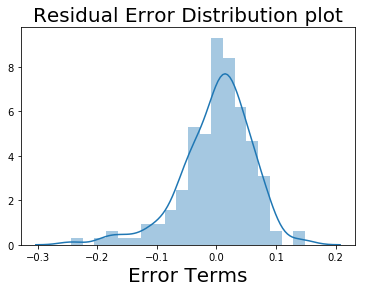

In [1450]:
# Check normality of distribution of residuals
plt.figure()
sns.distplot(y_train_pred - y_train,bins=20)
plt.title("Residual Error Distribution plot",fontsize=20)
plt.xlabel('Error Terms',fontsize=20)

Text(0.5, 1.0, 'Checking for patterns in residuals')

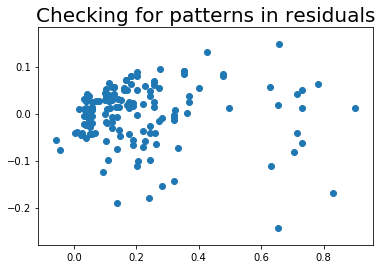

In [1462]:
plt.scatter(y_train_pred,y_train_pred - y_train)
plt.title("Checking for patterns in residuals",fontsize=20)

##### *The residuals have constant variance hence `homoscedastic` and there is `no autocorrelation` betwen data points*

## Prediction on test data

In [1303]:
df_test.head()

wheelbase  carlength  carwidth  carheight  curbweight  enginesize  \
131   0.276968   0.532836  0.538462   0.154545    0.377036    0.287449   
117   0.623907   0.680597  0.683761   0.654545    0.636928    0.295547   
63    0.355685   0.547761  0.529915   0.609091    0.370442    0.246964   
56    0.253644   0.416418  0.461538   0.072727    0.346005    0.036437   
49    0.448980   0.755224  0.880342  -0.090909    0.955004    1.072874   

     boreratio    stroke  compressionratio  horsepower   peakrpm   citympg  \
131   0.657143  0.871429           0.10625    0.264151  0.387755  0.257143   
117   0.764286  0.542857           0.00000    0.591195  0.591837  0.114286   
63    0.607143  0.628571           0.98125    0.100629  0.204082  0.628571   
56    0.564286  0.564286           0.15000    0.333333  0.755102  0.085714   
49    0.714286  0.328571           0.28125    1.345912  0.346939 -0.028571   

     highwaympg     price  symboling_-1  symboling_0  symboling_1  \
131    0.394737  0.118589             0            0            0   
117    0.210526  0.323519             0            1            0   
63     0.684211  0.140931             0            1            0   
56     0.184211  0.166998             0            0            0   
49     0.026316  0.766645             0            1            0   

     symboling_2  symboling_3  fueltype_gas  aspiration_turbo  doornumber_two  \
131            1            0             1                 0               1   
117            0            0             1                 1               0   
63             0            0             0                 0               0   
56             0            1             1                 0               1   
49             0            0             1                 0               1   

     carbody_hardtop  carbody_hatchback  carbody_sedan  carbody_wagon  \
131                0                  1              0              0   
117                0                  0              1              0   
63                 0                  0              1              0   
56                 0                  1              0              0   
49                 0                  0              1              0   

     companyname_alfa-romero  companyname_audi  companyname_bmw  \
131                        0                 0                0   
117                        0                 0                0   
63                         0                 0                0   
56                         0                 0                0   
49                         0                 0                0   

     companyname_buick  companyname_chevrolet  companyname_dodge  \
131                  0                      0                  0   
117                  0                      0                  0   
63                   0                      0                  0   
56                   0                      0                  0   
49                   0                      0                  0   

     companyname_honda  companyname_isuzu  companyname_jaguar  \
131                  0                  0                   0   
117                  0                  0                   0   
63                   0                  0                   0   
56                   0                  0                   0   
49                   0                  0                   1   

     companyname_mazda  companyname_mercury  companyname_mitsubishi  \
131                  0                    0                       0   
117                  0                    0                       0   
63                   1                    0                       0   
56                   1                    0                       0   
49                   0                    0                       0   

     companyname_nissan  companyname_peugeot  companyname_plymouth  \
131                   0                    0      

In [1258]:
# Use the scaler object fitted on training data to scale variables in test set.
df_test[num_cols] = scaler.transform(df_test[num_cols])
df_test.head()

wheelbase  carlength  carwidth  carheight  curbweight  enginesize  \
131   0.276968   0.532836  0.538462   0.154545    0.377036    0.287449   
117   0.623907   0.680597  0.683761   0.654545    0.636928    0.295547   
63    0.355685   0.547761  0.529915   0.609091    0.370442    0.246964   
56    0.253644   0.416418  0.461538   0.072727    0.346005    0.036437   
49    0.448980   0.755224  0.880342  -0.090909    0.955004    1.072874   

     boreratio    stroke  compressionratio  horsepower   peakrpm   citympg  \
131   0.657143  0.871429           0.10625    0.264151  0.387755  0.257143   
117   0.764286  0.542857           0.00000    0.591195  0.591837  0.114286   
63    0.607143  0.628571           0.98125    0.100629  0.204082  0.628571   
56    0.564286  0.564286           0.15000    0.333333  0.755102  0.085714   
49    0.714286  0.328571           0.28125    1.345912  0.346939 -0.028571   

     highwaympg     price  symboling_-1  symboling_0  symboling_1  \
131    0.394737  0.118589             0            0            0   
117    0.210526  0.323519             0            1            0   
63     0.684211  0.140931             0            1            0   
56     0.184211  0.166998             0            0            0   
49     0.026316  0.766645             0            1            0   

     symboling_2  symboling_3  fueltype_gas  aspiration_turbo  doornumber_two  \
131            1            0             1                 0               1   
117            0            0             1                 1               0   
63             0            0             0                 0               0   
56             0            1             1                 0               1   
49             0            0             1                 0               1   

     carbody_hardtop  carbody_hatchback  carbody_sedan  carbody_wagon  \
131                0                  1              0              0   
117                0                  0              1              0   
63                 0                  0              1              0   
56                 0                  1              0              0   
49                 0                  0              1              0   

     companyname_alfa-romero  companyname_audi  companyname_bmw  \
131                        0                 0                0   
117                        0                 0                0   
63                         0                 0                0   
56                         0                 0                0   
49                         0                 0                0   

     companyname_buick  companyname_chevrolet  companyname_dodge  \
131                  0                      0                  0   
117                  0                      0                  0   
63                   0                      0                  0   
56                   0                      0                  0   
49                   0                      0                  0   

     companyname_honda  companyname_isuzu  companyname_jaguar  \
131                  0                  0                   0   
117                  0                  0                   0   
63                   0                  0                   0   
56                   0                  0                   0   
49                   0                  0                   1   

     companyname_mazda  companyname_mercury  companyname_mitsubishi  \
131                  0                    0                       0   
117                  0                    0                       0   
63                   1                    0                       0   
56                   1                    0                       0   
49                   0                    0                       0   

     companyname_nissan  companyname_peugeot  companyname_plymouth  \
131                   0                    0      

In [1452]:
# split the test data into X and y variables
X_test = df_test.drop('price',axis=1)
y_test = df_test['price']

In [1453]:
X_test.shape

(41, 69)

In [1454]:
y_test.shape

(41,)

In [1455]:
# Using only columns finalized during feature selection
X_test = X_test[sel_cols]
X_test.shape

(41, 6)

In [1456]:
#Add constant as required by Linear Regression model of Statsmodels
X_test = sm.add_constant(X_test)
X_test.shape

(41, 7)

In [1457]:
# Prediction of test data
y_test_pred = lr_sm.predict(X_test)

## Model Evaluation

- When you're done with model building and residual analysis, and have made predictions on the test set, just make sure you use the following two lines of code to calculate the R-squared score on the test set.
 

In [1458]:
# r2 scrore for the predicted values
from sklearn.metrics import r2_score
r2_score(y_test, y_test_pred)

0.8483481562748955

Text(0, 0.5, 'y_pred')

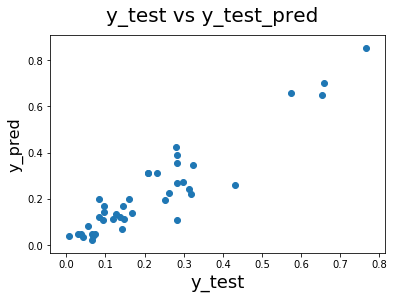

In [1459]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label